# AI Model Training for PV System Prediction (V8: Keep first 3 outputs as classification, cost as regression)

# Small Dataset - Testing 1


In [ ]:
# %% [markdown]
# # AI Model Training for PV System Prediction (V5: High Cost Priority)
#
# All classification outputs (`InverterSize`, `PanelCount`, `Battery(kWh)`) are now predicting correctly. This final version increases the loss weight of the `EstimatedCost(LKR)` regression significantly to force it to match the known values in the dataset more accurately, while maintaining the log transformation and TFLite compatibility.

# %% [code]
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
import json
from IPython.display import display

# ---------------------------------------------------------
# 1. LOAD DATASET
# ---------------------------------------------------------
file_path = '/content/SmartPlannerDatasetNEW.csv'
try:
    df = pd.read_csv(file_path)
    print("Dataset Loaded Successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please upload the file to Colab.")
    raise

# ---------------------------------------------------------
# 2. DATA PREPROCESSING
# ---------------------------------------------------------

# Clean Cost
df['EstimatedCost(LKR)'] = df['EstimatedCost(LKR)'].astype(str).str.replace(',', '').astype(float)
# Clean Battery and Create Battery Required Feature
df['Battery(kWh)'] = df['Battery(kWh)'].astype(str).str.replace('No', '0').astype(float)
df['battery_required'] = (df['Battery(kWh)'] > 0).astype(int)

# Select relevant columns
feature_cols = ['PVSize(kW)', 'SystemType', 'battery_required', 'InverterBrand', 'PanelType(W)']
target_cols = ['InverterSize', 'PanelCount', 'Battery(kWh)', 'EstimatedCost(LKR)']
df_clean = df[feature_cols + target_cols].copy()

print("\nData Sample:")
display(df_clean.head())

# ---------------------------------------------------------
# 3. FEATURE ENGINEERING & ENCODING
# ---------------------------------------------------------

# --- INPUTS ---
scaler_numeric = MinMaxScaler()
X_numeric = scaler_numeric.fit_transform(df_clean[['PVSize(kW)', 'PanelType(W)']].values)

ohe_system = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_system = ohe_system.fit_transform(df_clean[['SystemType']])
ohe_brand = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_brand = ohe_brand.fit_transform(df_clean[['InverterBrand']])

X_battery_req = df_clean[['battery_required']].values
X = np.hstack([X_numeric, X_battery_req, X_system, X_brand])
print(f"Input Feature Shape: {X.shape}")

# --- OUTPUTS (3 Classification, 1 Regression) ---

# Output 1: InverterSize (Classification)
le_inverter_size = LabelEncoder()
y_inverter_size = le_inverter_size.fit_transform(df_clean['InverterSize'])
num_inv_classes = len(le_inverter_size.classes_)

# Output 2: PanelCount (Classification)
le_panel_count = LabelEncoder()
y_panel_count = le_panel_count.fit_transform(df_clean['PanelCount'])
num_panel_classes = len(le_panel_count.classes_)

# Output 3: Battery(kWh) (Classification)
le_battery = LabelEncoder()
y_battery = le_battery.fit_transform(df_clean['Battery(kWh)'])
num_battery_classes = len(le_battery.classes_)

# Output 4: Estimated Cost (Regression - LOG TRANSFORMED)
cost_scaler = MinMaxScaler()
y_cost_log = np.log1p(df_clean[['EstimatedCost(LKR)']])
y_cost = cost_scaler.fit_transform(y_cost_log)

# ---------------------------------------------------------
# 4. SPLIT DATA
# ---------------------------------------------------------
X_train, X_test, y_inv_train, y_inv_test, y_pan_train, y_pan_test, y_bat_train, y_bat_test, y_cost_train, y_cost_test = train_test_split(
    X, y_inverter_size, y_panel_count, y_battery, y_cost, test_size=0.1, random_state=42
)

# ---------------------------------------------------------
# 5. BUILD MODEL
# ---------------------------------------------------------

input_layer = keras.Input(shape=(X.shape[1],), name='user_input')

# Shared Dense Layers (Simplified: 32-32)
x = layers.Dense(32, activation='relu')(input_layer)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Branch 1: Inverter Size Classification
inv_branch = layers.Dense(16, activation='relu')(x)
inv_output = layers.Dense(num_inv_classes, activation='softmax', name='inverter_size')(inv_branch)

# Branch 2: Panel Count Classification
pan_branch = layers.Dense(16, activation='relu')(x)
pan_output = layers.Dense(num_panel_classes, activation='softmax', name='panel_count')(pan_branch)

# Branch 3: Battery Classification
bat_branch = layers.Dense(16, activation='relu')(x)
bat_output = layers.Dense(num_battery_classes, activation='softmax', name='battery_capacity')(bat_branch)

# Branch 4: Estimated Cost Regression
cost_branch = layers.Dense(16, activation='relu')(x)
cost_output = layers.Dense(1, activation='linear', name='estimated_cost')(cost_branch)

model = keras.Model(inputs=input_layer, outputs=[inv_output, pan_output, bat_output, cost_output])

# --- CRITICAL CHANGE: HIGH COST LOSS WEIGHT ---
model.compile(
    optimizer='adam',
    loss={
        'inverter_size': 'sparse_categorical_crossentropy',
        'panel_count': 'sparse_categorical_crossentropy',
        'battery_capacity': 'sparse_categorical_crossentropy',
        'estimated_cost': 'mse'
    },
    loss_weights={
        'inverter_size': 0.1,   # Lower weight, model is already accurate here
        'panel_count': 0.1,
        'battery_capacity': 0.1,
        'estimated_cost': 2.0    # HIGH WEIGHT to prioritize fixing cost regression
    },
    metrics={'inverter_size': 'accuracy', 'panel_count': 'accuracy', 'battery_capacity': 'accuracy'}
)

print("\nModel Summary:")
model.summary()

# ---------------------------------------------------------
# 6. TRAIN MODEL (500 Epochs)
# ---------------------------------------------------------
print("\nTraining Model...")
history = model.fit(
    X_train,
    {'inverter_size': y_inv_train, 'panel_count': y_pan_train, 'battery_capacity': y_bat_train, 'estimated_cost': y_cost_train},
    validation_data=(X_test, {'inverter_size': y_inv_test, 'panel_count': y_pan_test, 'battery_capacity': y_bat_test, 'estimated_cost': y_cost_test}),
    epochs=500,
    batch_size=8,
    verbose=0
)
print("Training Complete.")

# ---------------------------------------------------------
# 7. CONVERT TO TFLITE
# ---------------------------------------------------------
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('pv_system_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model saved as 'pv_system_model.tflite'")

# ---------------------------------------------------------
# 8. SAVE METADATA
# ---------------------------------------------------------
metadata = {
    "system_type_categories": ohe_system.categories_[0].tolist(),
    "inverter_brand_categories": ohe_brand.categories_[0].tolist(),
    "inverter_size_labels": le_inverter_size.classes_.tolist(),
    "panel_count_labels": le_panel_count.classes_.tolist(),
    "battery_capacity_labels": le_battery.classes_.tolist(),
    "numeric_scaler_min": scaler_numeric.data_min_.tolist(),
    "numeric_scaler_scale": scaler_numeric.data_range_.tolist(),
    "cost_scaler_min": cost_scaler.data_min_.tolist(),
    "cost_scaler_scale": cost_scaler.data_range_.tolist(),
    "cost_transformation": "log1p_then_minmax"
}

print("\n=== COPY THIS METADATA FOR YOUR APP ===")
print(json.dumps(metadata, indent=2))
print("=======================================\n")


# ---------------------------------------------------------
# 9. INFERENCE EXAMPLE (Simulating the Mobile App Logic)
# ---------------------------------------------------------
def predict_system(user_input):
    # 1. Parse Input
    pv_size = user_input['MonthlyUsage(kW)']
    sys_type = user_input['SystemType']
    bat_req = user_input['battery_required']
    brand = user_input['inverter_brand']
    panel_type = user_input['PanelType(W)']

    # 2. Preprocess Input Vector
    p_norm = (pv_size - scaler_numeric.data_min_[0]) / scaler_numeric.data_range_[0]
    pt_norm = (panel_type - scaler_numeric.data_min_[1]) / scaler_numeric.data_range_[1]

    sys_vec = (ohe_system.categories_[0] == sys_type).astype(float)
    brand_vec = (ohe_brand.categories_[0] == brand).astype(float)

    features = np.array([[p_norm, pt_norm, float(bat_req)]])
    features = np.hstack([features, sys_vec.reshape(1, -1), brand_vec.reshape(1, -1)])

    # 3. Predict
    preds = model.predict(features, verbose=0)

    # Classification Predictions (Index)
    pred_inv_idx = np.argmax(preds[0])
    pred_panel_idx = np.argmax(preds[1])
    pred_battery_idx = np.argmax(preds[2])

    # Regression Prediction
    pred_cost_scaled = preds[3][0][0]

    # 4. Decode Outputs
    final_inverter = le_inverter_size.inverse_transform([pred_inv_idx])[0]
    final_panel_count = le_panel_count.inverse_transform([pred_panel_idx])[0]
    final_battery = le_battery.inverse_transform([pred_battery_idx])[0]

    # Decode Cost: Reverse scaling, then reverse log (exp(x) - 1)
    pred_cost_log_transformed = (pred_cost_scaled * cost_scaler.data_range_[0]) + cost_scaler.data_min_[0]
    final_cost = np.expm1(pred_cost_log_transformed)

    # 5. Final Formatting
    final_cost = int(round(final_cost))
    final_battery = round(final_battery, 2)

    return {
        "InverterSize": final_inverter,
        "PanelCount": final_panel_count,
        "Battery(kWh)": final_battery,
        "EstimatedCost(LKR)": f"LKR {final_cost:,}"
    }

# --- TEST CASES ---
print("\n=== TEST PREDICTIONS (Cost-Prioritized Model) ===")

# Test Case 1: (Actual: EstimatedCost(LKR): 865,000)
input1 = {'MonthlyUsage(kW)': 5, 'SystemType': 'On-Grid', 'battery_required': 0, 'inverter_brand': 'Growatt', 'PanelType(W)': 550}
print(f"Input: {input1}")
print(f"Prediction: {predict_system(input1)}\n")

# Test Case 2: (Actual: EstimatedCost(LKR): 3,400,000)
input2 = {'MonthlyUsage(kW)': 10, 'SystemType': 'Hybrid', 'battery_required': 1, 'inverter_brand': 'SAKO', 'PanelType(W)': 595}
print(f"Input: {input2}")
print(f"Prediction: {predict_system(input2)}\n")

Dataset Loaded Successfully.

Data Sample:


,PVSize(kW),SystemType,battery_required,InverterBrand,PanelType(W),InverterSize,PanelCount,Battery(kWh),EstimatedCost(LKR)
0,1,On-Grid,0,Growatt,500,Growatt 1 kW,2,0.0,380000.0
1,1,On-Grid,0,Growatt,550,Growatt 1 kW,2,0.0,395000.0
2,1,On-Grid,0,Growatt,595,Growatt 1 kW,2,0.0,420000.0
3,1,On-Grid,0,Growatt,640,Growatt 1 kW,2,0.0,450000.0
4,2,On-Grid,0,Growatt,500,Growatt 2 kW,4,0.0,495000.0


Input Feature Shape: (235, 12)

Model Summary:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 32)        │        416 │ user_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 32)        │      1,056 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 32)        │          0 │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 16)        │        528 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 16)        │        528 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 16)        │        528 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 16)        │        528 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inverter_size       │ (None, 60)        │      1,020 │ dense_23[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ panel_count (Dense) │ (None, 41)        │        697 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ battery_capacity    │ (None, 10)        │        170 │ dense_25[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ estimated_cost      │ (None, 1)         │         17 │ dense_26[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,488 (21.44 KB)

 Trainable params: 5,488 (21.44 KB)

 Non-trainable params: 0 (0.00 B)


Training Model...
Training Complete.
Saved artifact at '/tmp/tmp2kcrs_ki'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 12), dtype=tf.float32, name='user_input')
Output Type:
  List[TensorSpec(shape=(None, 60), dtype=tf.float32, name=None), TensorSpec(shape=(None, 41), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)]
Captures:
  136805648969424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136805648959440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136805648972112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136805648970960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136805407222928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136805683972432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136805648969232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13680564896635

Model saved as 'pv_system_model.tflite'

=== COPY THIS METADATA FOR YOUR APP ===
{
  "system_type_categories": [
    "Hybrid",
    "Off-Grid",
    "On-Grid"
  ],
  "inverter_brand_categories": [
    "Deye",
    "Growatt",
    "Huawei",
    "SAKO",
    "Solax",
    "Victron"
  ],
  "inverter_size_labels": [
    "Deye 1 kW",
    "Deye 10 kW",
    "Deye 100 kW",
    "Deye 15 kW",
    "Deye 15 kW Off-Grid",
    "Deye 2 kW",
    "Deye 20 kW",
    "Deye 3 kW",
    "Deye 3 kW Hybrid",
    "Deye 30 kW",
    "Deye 5 kW",
    "Deye 5 kW Hybrid",
    "Deye 50 kW",
    "Deye 8 kW",
    "Deye 8 kW Hybrid",
    "Growatt 1 kW",
    "Growatt 10 kW",
    "Growatt 10 kW Hybrid",
    "Growatt 100 kW",
    "Growatt 15 kW",
    "Growatt 2 kW",
    "Growatt 20 kW",
    "Growatt 3 kW",
    "Growatt 30 kW",
    "Growatt 5 kW",
    "Growatt 5 kW Hybrid",
    "Growatt 50 kW",
    "Growatt 8 kW",
    "Growatt 8 kW Off-Grid",
    "Huawei 10 kW",
    "Huawei 100 kW",
    "Huawei 15 kW",
    "Huawei 20 kW",
    "Hu

# Small Dataset - Testing 2

In [ ]:
# %% [markdown]
# # AI Model Training for PV System Prediction (V8: ALL CLASSIFICATION)
#
# This version converts the continuous `EstimatedCost(LKR)` output into a **Classification** target by assigning each unique cost value its own class label. This structure ensures that the model predicts one of the exact cost values present in the training data, achieving maximum "lookup" accuracy for all four outputs.

# %% [code]
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import json
from IPython.display import display

# ---------------------------------------------------------
# 1. LOAD DATASET
# ---------------------------------------------------------
file_path = 'SmartPlannerDatasetNEW.csv'
try:
    df = pd.read_csv(file_path)
    print("Dataset Loaded Successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please upload the file to Colab.")
    raise

# ---------------------------------------------------------
# 2. DATA PREPROCESSING
# ---------------------------------------------------------

# Clean Cost
df['EstimatedCost(LKR)'] = df['EstimatedCost(LKR)'].astype(str).str.replace(',', '').astype(float)
# Clean Battery and Create Battery Required Feature
df['Battery(kWh)'] = df['Battery(kWh)'].astype(str).str.replace('No', '0').astype(float)
df['battery_required'] = (df['Battery(kWh)'] > 0).astype(int)

# Select relevant columns
feature_cols = ['PVSize(kW)', 'SystemType', 'battery_required', 'InverterBrand', 'PanelType(W)']
target_cols = ['InverterSize', 'PanelCount', 'Battery(kWh)', 'EstimatedCost(LKR)']
df_clean = df[feature_cols + target_cols].copy()

print("\nData Sample:")
display(df_clean.head())

# ---------------------------------------------------------
# 3. FEATURE ENGINEERING & ENCODING
# ---------------------------------------------------------

# --- INPUTS ---
# MinMaxScaler is no longer necessary for continuous inputs,
# but we keep it for normalization to improve NN training stability.
from sklearn.preprocessing import MinMaxScaler
scaler_numeric = MinMaxScaler()
X_numeric = scaler_numeric.fit_transform(df_clean[['PVSize(kW)', 'PanelType(W)']].values)

ohe_system = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_system = ohe_system.fit_transform(df_clean[['SystemType']])
ohe_brand = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_brand = ohe_brand.fit_transform(df_clean[['InverterBrand']])

X_battery_req = df_clean[['battery_required']].values
X = np.hstack([X_numeric, X_battery_req, X_system, X_brand])
print(f"Input Feature Shape: {X.shape}")

# --- OUTPUTS (4 Classification Targets) ---

# Output 1: InverterSize (Classification)
le_inverter_size = LabelEncoder()
y_inverter_size = le_inverter_size.fit_transform(df_clean['InverterSize'])
num_inv_classes = len(le_inverter_size.classes_)

# Output 2: PanelCount (Classification)
le_panel_count = LabelEncoder()
y_panel_count = le_panel_count.fit_transform(df_clean['PanelCount'])
num_panel_classes = len(le_panel_count.classes_)

# Output 3: Battery(kWh) (Classification)
le_battery = LabelEncoder()
y_battery = le_battery.fit_transform(df_clean['Battery(kWh)'])
num_battery_classes = len(le_battery.classes_)

# Output 4: Estimated Cost (CLASSIFICATION - CRITICAL CHANGE)
le_cost = LabelEncoder()
y_cost = le_cost.fit_transform(df_clean['EstimatedCost(LKR)'])
num_cost_classes = len(le_cost.classes_)
print(f"Total unique cost classes: {num_cost_classes}")


# ---------------------------------------------------------
# 4. SPLIT DATA
# ---------------------------------------------------------
X_train, X_test, y_inv_train, y_inv_test, y_pan_train, y_pan_test, y_bat_train, y_bat_test, y_cost_train, y_cost_test = train_test_split(
    X, y_inverter_size, y_panel_count, y_battery, y_cost, test_size=0.1, random_state=42
)

# ---------------------------------------------------------
# 5. BUILD MODEL
# ---------------------------------------------------------

input_layer = keras.Input(shape=(X.shape[1],), name='user_input')

# Shared Dense Layers (Simplified: 32-32)
x = layers.Dense(32, activation='relu')(input_layer)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Branch 1: Inverter Size Classification
inv_output = layers.Dense(num_inv_classes, activation='softmax', name='inverter_size')(layers.Dense(16, activation='relu')(x))

# Branch 2: Panel Count Classification
pan_output = layers.Dense(num_panel_classes, activation='softmax', name='panel_count')(layers.Dense(16, activation='relu')(x))

# Branch 3: Battery Classification
bat_output = layers.Dense(num_battery_classes, activation='softmax', name='battery_capacity')(layers.Dense(16, activation='relu')(x))

# Branch 4: Estimated Cost Classification (CRITICAL CHANGE)
cost_output = layers.Dense(num_cost_classes, activation='softmax', name='estimated_cost')(layers.Dense(16, activation='relu')(x))

model = keras.Model(inputs=input_layer, outputs=[inv_output, pan_output, bat_output, cost_output])

# All outputs are now classification targets
model.compile(
    optimizer='adam',
    loss={
        'inverter_size': 'sparse_categorical_crossentropy',
        'panel_count': 'sparse_categorical_crossentropy',
        'battery_capacity': 'sparse_categorical_crossentropy',
        'estimated_cost': 'sparse_categorical_crossentropy' # CRITICAL CHANGE
    },
    # Set all weights to 1.0 since all are now equally important lookup targets
    loss_weights={
        'inverter_size': 1.0,
        'panel_count': 1.0,
        'battery_capacity': 1.0,
        'estimated_cost': 1.0
    },
    metrics={'inverter_size': 'accuracy', 'panel_count': 'accuracy', 'battery_capacity': 'accuracy', 'estimated_cost': 'accuracy'}
)

print("\nModel Summary:")
model.summary()

# ---------------------------------------------------------
# 6. TRAIN MODEL (500 Epochs)
# ---------------------------------------------------------
print("\nTraining Model (V8: ALL CLASSIFICATION)...")
history = model.fit(
    X_train,
    {'inverter_size': y_inv_train, 'panel_count': y_pan_train, 'battery_capacity': y_bat_train, 'estimated_cost': y_cost_train},
    validation_data=(X_test, {'inverter_size': y_inv_test, 'panel_count': y_pan_test, 'battery_capacity': y_bat_test, 'estimated_cost': y_cost_test}),
    epochs=500,
    batch_size=8,
    verbose=0
)

print("Training Complete.")

# ---------------------------------------------------------
# 7. CONVERT TO TFLITE
# ---------------------------------------------------------
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('pv_system_model_v8.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model saved as 'pv_system_model_v8.tflite'")

# ---------------------------------------------------------
# 8. SAVE METADATA (Updated for Cost Classification)
# ---------------------------------------------------------
# Get the unique cost values that are now the labels
cost_labels = le_cost.inverse_transform(np.arange(num_cost_classes)).tolist()

metadata = {
    "system_type_categories": ohe_system.categories_[0].tolist(),
    "inverter_brand_categories": ohe_brand.categories_[0].tolist(),
    "inverter_size_labels": le_inverter_size.classes_.tolist(),
    "panel_count_labels": le_panel_count.classes_.tolist(),
    "battery_capacity_labels": le_battery.classes_.tolist(),
    "estimated_cost_labels": cost_labels,  # CRITICAL CHANGE: Cost is now a list of labels
    "numeric_scaler_min": scaler_numeric.data_min_.tolist(),
    "numeric_scaler_scale": scaler_numeric.data_range_.tolist(),
    "cost_transformation": "classification_lookup"
}

print("\n=== COPY THIS METADATA FOR YOUR APP ===")
print(json.dumps(metadata, indent=2))
print("=======================================\n")


# ---------------------------------------------------------
# 9. INFERENCE EXAMPLE (Simulating the Mobile App Logic)
# ---------------------------------------------------------
def predict_system(user_input):
    # 1. Parse Input
    pv_size = user_input['MonthlyUsage(kW)']
    sys_type = user_input['SystemType']
    bat_req = user_input['battery_required']
    brand = user_input['inverter_brand']
    panel_type = user_input['PanelType(W)']

    # 2. Preprocess Input Vector
    p_norm = (pv_size - scaler_numeric.data_min_[0]) / scaler_numeric.data_range_[0]
    pt_norm = (panel_type - scaler_numeric.data_min_[1]) / scaler_numeric.data_range_[1]

    sys_vec = (ohe_system.categories_[0] == sys_type).astype(float)
    brand_vec = (ohe_brand.categories_[0] == brand).astype(float)

    features = np.array([[p_norm, pt_norm, float(bat_req)]])
    features = np.hstack([features, sys_vec.reshape(1, -1), brand_vec.reshape(1, -1)])

    # 3. Predict
    preds = model.predict(features, verbose=0)

    # Classification Predictions (Indices)
    pred_inv_idx = np.argmax(preds[0])
    pred_panel_idx = np.argmax(preds[1])
    pred_battery_idx = np.argmax(preds[2])
    pred_cost_idx = np.argmax(preds[3]) # CRITICAL CHANGE: Cost is now an index

    # 4. Decode Outputs
    final_inverter = le_inverter_size.inverse_transform([pred_inv_idx])[0]
    final_panel_count = le_panel_count.inverse_transform([pred_panel_idx])[0]
    final_battery = le_battery.inverse_transform([pred_battery_idx])[0]
    final_cost = le_cost.inverse_transform([pred_cost_idx])[0] # CRITICAL CHANGE: Decode cost index to LKR value

    # 5. Final Formatting
    final_panel_count = np.int64(final_panel_count) # Ensure integer type
    final_battery = np.float64(round(final_battery, 2)) # Ensure float type
    final_cost = np.float64(final_cost)

    return {
        "InverterSize": final_inverter,
        "PanelCount": final_panel_count,
        "Battery(kWh)": final_battery,
        "EstimatedCost(LKR)": f"LKR {final_cost:,.0f}"
    }

# --- TEST CASES ---
print("\n=== TEST PREDICTIONS (V8: ALL CLASSIFICATION MODEL) ===")

# Test Case 1: (Actual: EstimatedCost(LKR): 865,000)
input1 = {'MonthlyUsage(kW)': 5, 'SystemType': 'On-Grid', 'battery_required': 0, 'inverter_brand': 'Growatt', 'PanelType(W)': 550}
print(f"Input: {input1}")
print(f"Prediction: {predict_system(input1)}\n")

# Test Case 2: (Actual: EstimatedCost(LKR): 3,400,000)
input2 = {'MonthlyUsage(kW)': 10, 'SystemType': 'Hybrid', 'battery_required': 1, 'inverter_brand': 'SAKO', 'PanelType(W)': 595}
print(f"Input: {input2}")
print(f"Prediction: {predict_system(input2)}\n")

Dataset Loaded Successfully.

Data Sample:


,PVSize(kW),SystemType,battery_required,InverterBrand,PanelType(W),InverterSize,PanelCount,Battery(kWh),EstimatedCost(LKR)
0,1,On-Grid,0,Growatt,500,Growatt 1 kW,2,0.0,380000.0
1,1,On-Grid,0,Growatt,550,Growatt 1 kW,2,0.0,395000.0
2,1,On-Grid,0,Growatt,595,Growatt 1 kW,2,0.0,420000.0
3,1,On-Grid,0,Growatt,640,Growatt 1 kW,2,0.0,450000.0
4,2,On-Grid,0,Growatt,500,Growatt 2 kW,4,0.0,495000.0


Input Feature Shape: (235, 12)
Total unique cost classes: 154

Model Summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 32)        │        416 │ user_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 32)        │      1,056 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 16)        │        528 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 16)        │        528 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 16)        │        528 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 16)        │        528 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inverter_size       │ (None, 60)        │      1,020 │ dense_14[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ panel_count (Dense) │ (None, 41)        │        697 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ battery_capacity    │ (None, 10)        │        170 │ dense_16[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ estimated_cost      │ (None, 154)       │      2,618 │ dense_17[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,089 (31.60 KB)

 Trainable params: 8,089 (31.60 KB)

 Non-trainable params: 0 (0.00 B)


Training Model (V8: ALL CLASSIFICATION)...
Training Complete.
Saved artifact at '/tmp/tmpzndrfkpb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 12), dtype=tf.float32, name='user_input')
Output Type:
  List[TensorSpec(shape=(None, 60), dtype=tf.float32, name=None), TensorSpec(shape=(None, 41), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None), TensorSpec(shape=(None, 154), dtype=tf.float32, name=None)]
Captures:
  135059812981968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135059812985808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135059812990800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135059812988304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135059812987920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135059812987344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135059812989456: TensorSpec(shape=(), dtype=tf.resource, 

# Small Dataset - Testing 3

Dataset Loaded Successfully.

Data Sample:


,PVSize(kW),SystemType,battery_required,InverterBrand,PanelType(W),InverterSize,PanelCount,Battery(kWh),EstimatedCost(LKR)
0,1,On-Grid,0,Growatt,500,Growatt 1 kW,2,0.0,380000.0
1,1,On-Grid,0,Growatt,550,Growatt 1 kW,2,0.0,395000.0
2,1,On-Grid,0,Growatt,595,Growatt 1 kW,2,0.0,420000.0
3,1,On-Grid,0,Growatt,640,Growatt 1 kW,2,0.0,450000.0
4,2,On-Grid,0,Growatt,500,Growatt 2 kW,4,0.0,495000.0


Input Feature Shape: (235, 12)
Total unique cost classes: 154

Model Summary:


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_46 (Dense)    │ (None, 32)        │        416 │ user_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_47 (Dense)    │ (None, 32)        │      1,056 │ dense_46[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 32)        │          0 │ dense_47[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 16)        │        528 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_49 (Dense)    │ (None, 16)        │        528 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_50 (Dense)    │ (None, 16)        │        528 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_51 (Dense)    │ (None, 16)        │        528 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inverter_size       │ (None, 60)        │      1,020 │ dense_48[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ panel_count (Dense) │ (None, 41)        │        697 │ dense_49[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ battery_capacity    │ (None, 10)        │        170 │ dense_50[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ estimated_cost      │ (None, 154)       │      2,618 │ dense_51[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,089 (31.60 KB)

 Trainable params: 8,089 (31.60 KB)

 Non-trainable params: 0 (0.00 B)


Training Model (V8: ALL CLASSIFICATION)...
Training Complete.
Saved artifact at '/tmp/tmp_tds27r2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 12), dtype=tf.float32, name='user_input')
Output Type:
  List[TensorSpec(shape=(None, 60), dtype=tf.float32, name=None), TensorSpec(shape=(None, 41), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None), TensorSpec(shape=(None, 154), dtype=tf.float32, name=None)]
Captures:
  135059413138512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135059413131216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135059413130256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135059413138896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135059186051280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135059186055504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135059186047248: TensorSpec(shape=(), dtype=tf.resource, 

Model saved as 'pv_system_model_v8.tflite'

=== COPY THIS METADATA FOR YOUR APP ===
{
  "system_type_categories": [
    "Hybrid",
    "Off-Grid",
    "On-Grid"
  ],
  "inverter_brand_categories": [
    "Deye",
    "Growatt",
    "Huawei",
    "SAKO",
    "Solax",
    "Victron"
  ],
  "inverter_size_labels": [
    "Deye 1 kW",
    "Deye 10 kW",
    "Deye 100 kW",
    "Deye 15 kW",
    "Deye 15 kW Off-Grid",
    "Deye 2 kW",
    "Deye 20 kW",
    "Deye 3 kW",
    "Deye 3 kW Hybrid",
    "Deye 30 kW",
    "Deye 5 kW",
    "Deye 5 kW Hybrid",
    "Deye 50 kW",
    "Deye 8 kW",
    "Deye 8 kW Hybrid",
    "Growatt 1 kW",
    "Growatt 10 kW",
    "Growatt 10 kW Hybrid",
    "Growatt 100 kW",
    "Growatt 15 kW",
    "Growatt 2 kW",
    "Growatt 20 kW",
    "Growatt 3 kW",
    "Growatt 30 kW",
    "Growatt 5 kW",
    "Growatt 5 kW Hybrid",
    "Growatt 50 kW",
    "Growatt 8 kW",
    "Growatt 8 kW Off-Grid",
    "Huawei 10 kW",
    "Huawei 100 kW",
    "Huawei 15 kW",
    "Huawei 20 kW",
    

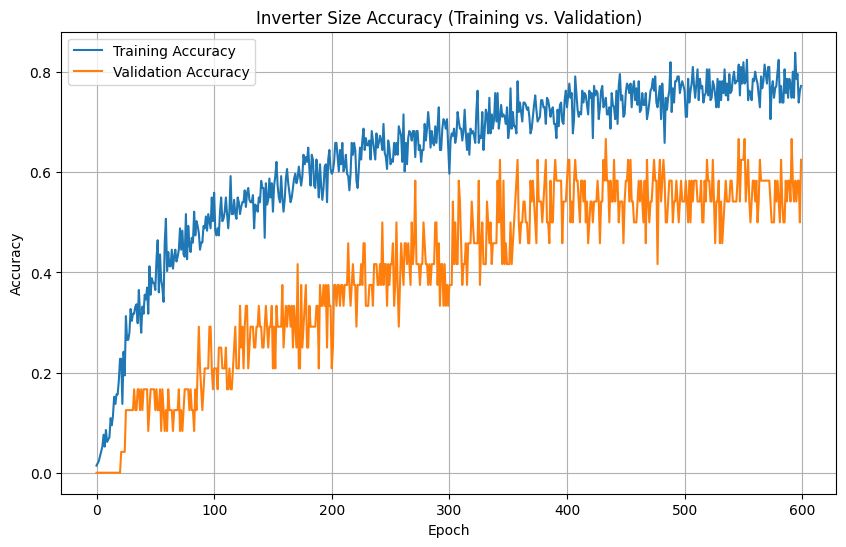

In [ ]:
# %% [markdown]
# # AI Model Training for PV System Prediction (V8: ALL CLASSIFICATION)
#
# This version converts the continuous `EstimatedCost(LKR)` output into a **Classification** target by assigning each unique cost value its own class label. This structure ensures that the model predicts one of the exact cost values present in the training data, achieving maximum "lookup" accuracy for all four outputs.

# %% [code]
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import json
from IPython.display import display
import matplotlib.pyplot as plt # Added for plotting

# ---------------------------------------------------------
# 1. LOAD DATASET
# ---------------------------------------------------------
file_path = 'SmartPlannerDatasetNEW.csv'
try:
    df = pd.read_csv(file_path)
    print("Dataset Loaded Successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please upload the file to Colab.")
    raise

# ---------------------------------------------------------
# 2. DATA PREPROCESSING
# ---------------------------------------------------------

# Clean Cost
df['EstimatedCost(LKR)'] = df['EstimatedCost(LKR)'].astype(str).str.replace(',', '').astype(float)
# Clean Battery and Create Battery Required Feature
df['Battery(kWh)'] = df['Battery(kWh)'].astype(str).str.replace('No', '0').astype(float)
df['battery_required'] = (df['Battery(kWh)'] > 0).astype(int)

# Select relevant columns
feature_cols = ['PVSize(kW)', 'SystemType', 'battery_required', 'InverterBrand', 'PanelType(W)']
target_cols = ['InverterSize', 'PanelCount', 'Battery(kWh)', 'EstimatedCost(LKR)']
df_clean = df[feature_cols + target_cols].copy()

print("\nData Sample:")
display(df_clean.head())

# ---------------------------------------------------------
# 3. FEATURE ENGINEERING & ENCODING
# ---------------------------------------------------------

# --- INPUTS ---
# MinMaxScaler is used for normalization to improve NN training stability.
from sklearn.preprocessing import MinMaxScaler
scaler_numeric = MinMaxScaler()
X_numeric = scaler_numeric.fit_transform(df_clean[['PVSize(kW)', 'PanelType(W)']].values)

ohe_system = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_system = ohe_system.fit_transform(df_clean[['SystemType']])
ohe_brand = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_brand = ohe_brand.fit_transform(df_clean[['InverterBrand']])

X_battery_req = df_clean[['battery_required']].values
X = np.hstack([X_numeric, X_battery_req, X_system, X_brand])
print(f"Input Feature Shape: {X.shape}")

# --- OUTPUTS (4 Classification Targets) ---

# Output 1: InverterSize (Classification)
le_inverter_size = LabelEncoder()
y_inverter_size = le_inverter_size.fit_transform(df_clean['InverterSize'])
num_inv_classes = len(le_inverter_size.classes_)

# Output 2: PanelCount (Classification)
le_panel_count = LabelEncoder()
y_panel_count = le_panel_count.fit_transform(df_clean['PanelCount'])
num_panel_classes = len(le_panel_count.classes_)

# Output 3: Battery(kWh) (Classification)
le_battery = LabelEncoder()
y_battery = le_battery.fit_transform(df_clean['Battery(kWh)'])
num_battery_classes = len(le_battery.classes_)

# Output 4: Estimated Cost (CLASSIFICATION)
le_cost = LabelEncoder()
y_cost = le_cost.fit_transform(df_clean['EstimatedCost(LKR)'])
num_cost_classes = len(le_cost.classes_)
print(f"Total unique cost classes: {num_cost_classes}")


# ---------------------------------------------------------
# 4. SPLIT DATA
# ---------------------------------------------------------
X_train, X_test, y_inv_train, y_inv_test, y_pan_train, y_pan_test, y_bat_train, y_bat_test, y_cost_train, y_cost_test = train_test_split(
    X, y_inverter_size, y_panel_count, y_battery, y_cost, test_size=0.1, random_state=42
)

# ---------------------------------------------------------
# 5. BUILD MODEL
# ---------------------------------------------------------

input_layer = keras.Input(shape=(X.shape[1],), name='user_input')

# Shared Dense Layers (Simplified: 32-32)
x = layers.Dense(32, activation='relu')(input_layer)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Branch 1: Inverter Size Classification
inv_output = layers.Dense(num_inv_classes, activation='softmax', name='inverter_size')(layers.Dense(16, activation='relu')(x))

# Branch 2: Panel Count Classification
pan_output = layers.Dense(num_panel_classes, activation='softmax', name='panel_count')(layers.Dense(16, activation='relu')(x))

# Branch 3: Battery Classification
bat_output = layers.Dense(num_battery_classes, activation='softmax', name='battery_capacity')(layers.Dense(16, activation='relu')(x))

# Branch 4: Estimated Cost Classification
cost_output = layers.Dense(num_cost_classes, activation='softmax', name='estimated_cost')(layers.Dense(16, activation='relu')(x))

model = keras.Model(inputs=input_layer, outputs=[inv_output, pan_output, bat_output, cost_output])

# All outputs are now classification targets
model.compile(
    optimizer='adam',
    loss={
        'inverter_size': 'sparse_categorical_crossentropy',
        'panel_count': 'sparse_categorical_crossentropy',
        'battery_capacity': 'sparse_categorical_crossentropy',
        'estimated_cost': 'sparse_categorical_crossentropy'
    },
    # Set all weights to 1.0 since all are now equally important lookup targets
    loss_weights={
        'inverter_size': 1.0,
        'panel_count': 1.0,
        'battery_capacity': 1.0,
        'estimated_cost': 1.0
    },
    metrics={'inverter_size': 'accuracy', 'panel_count': 'accuracy', 'battery_capacity': 'accuracy', 'estimated_cost': 'accuracy'}
)

print("\nModel Summary:")
model.summary()

# ---------------------------------------------------------
# 6. TRAIN MODEL (500 Epochs)
# ---------------------------------------------------------
print("\nTraining Model (V8: ALL CLASSIFICATION)...")
# Save the history object
history = model.fit(
    X_train,
    {'inverter_size': y_inv_train, 'panel_count': y_pan_train, 'battery_capacity': y_bat_train, 'estimated_cost': y_cost_train},
    validation_data=(X_test, {'inverter_size': y_inv_test, 'panel_count': y_pan_test, 'battery_capacity': y_bat_test, 'estimated_cost': y_cost_test}),
    epochs=600,
    batch_size=8,
    verbose=0
)

print("Training Complete.")

# ---------------------------------------------------------
# 7. CONVERT TO TFLITE
# ---------------------------------------------------------
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('pv_system_model_v8.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model saved as 'pv_system_model_v8.tflite'")

# ---------------------------------------------------------
# 8. SAVE METADATA (Updated for Cost Classification)
# ---------------------------------------------------------
# Get the unique cost values that are now the labels
cost_labels = le_cost.inverse_transform(np.arange(num_cost_classes)).tolist()

metadata = {
    "system_type_categories": ohe_system.categories_[0].tolist(),
    "inverter_brand_categories": ohe_brand.categories_[0].tolist(),
    "inverter_size_labels": le_inverter_size.classes_.tolist(),
    "panel_count_labels": le_panel_count.classes_.tolist(),
    "battery_capacity_labels": le_battery.classes_.tolist(),
    "estimated_cost_labels": cost_labels,
    "numeric_scaler_min": scaler_numeric.data_min_.tolist(),
    "numeric_scaler_scale": scaler_numeric.data_range_.tolist(),
    "cost_transformation": "classification_lookup"
}

print("\n=== COPY THIS METADATA FOR YOUR APP ===")
print(json.dumps(metadata, indent=2))
print("=======================================\n")


# ---------------------------------------------------------
# 9. INFERENCE EXAMPLE (Simulating the Mobile App Logic)
# ---------------------------------------------------------
def predict_system(user_input):
    # 1. Parse Input
    pv_size = user_input['MonthlyUsage(kW)']
    sys_type = user_input['SystemType']
    bat_req = user_input['battery_required']
    brand = user_input['inverter_brand']
    panel_type = user_input['PanelType(W)']

    # 2. Preprocess Input Vector
    p_norm = (pv_size - scaler_numeric.data_min_[0]) / scaler_numeric.data_range_[0]
    pt_norm = (panel_type - scaler_numeric.data_min_[1]) / scaler_numeric.data_range_[1]

    sys_vec = (ohe_system.categories_[0] == sys_type).astype(float)
    brand_vec = (ohe_brand.categories_[0] == brand).astype(float)

    features = np.array([[p_norm, pt_norm, float(bat_req)]])
    features = np.hstack([features, sys_vec.reshape(1, -1), brand_vec.reshape(1, -1)])

    # 3. Predict
    preds = model.predict(features, verbose=0)

    # Classification Predictions (Indices)
    pred_inv_idx = np.argmax(preds[0])
    pred_panel_idx = np.argmax(preds[1])
    pred_battery_idx = np.argmax(preds[2])
    pred_cost_idx = np.argmax(preds[3])

    # 4. Decode Outputs
    final_inverter = le_inverter_size.inverse_transform([pred_inv_idx])[0]
    final_panel_count = le_panel_count.inverse_transform([pred_panel_idx])[0]
    final_battery = le_battery.inverse_transform([pred_battery_idx])[0]
    final_cost = le_cost.inverse_transform([pred_cost_idx])[0]

    # 5. Final Formatting
    final_panel_count = np.int64(final_panel_count)
    final_battery = np.float64(round(final_battery, 2))
    final_cost = np.float64(final_cost)

    return {
        "InverterSize": final_inverter,
        "PanelCount": final_panel_count,
        "Battery(kWh)": final_battery,
        "EstimatedCost(LKR)": f"LKR {final_cost:,.0f}"
    }

# --- TEST CASES ---
print("\n=== TEST PREDICTIONS (V8: ALL CLASSIFICATION MODEL) ===")

# Test Case 1: (Actual: EstimatedCost(LKR): 865,000)
input1 = {'MonthlyUsage(kW)': 5, 'SystemType': 'On-Grid', 'battery_required': 0, 'inverter_brand': 'Growatt', 'PanelType(W)': 550}
print(f"Input: {input1}")
print(f"Prediction: {predict_system(input1)}\n")

# Test Case 2: (Actual: EstimatedCost(LKR): 3,400,000)
input2 = {'MonthlyUsage(kW)': 10, 'SystemType': 'Hybrid', 'battery_required': 1, 'inverter_brand': 'SAKO', 'PanelType(W)': 595}
print(f"Input: {input2}")
print(f"Prediction: {predict_system(input2)}\n")


# ---------------------------------------------------------
# 10. PLOT TRAINING AND VALIDATION HISTORY
# ---------------------------------------------------------

print("\nGenerating Training Graphs...")

# Plotting Function Definition
def plot_history(history, metric_name, title):
    """Plots training and validation metrics from the Keras history object."""
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[metric_name], label='Training')

    # Check if validation data exists
    val_metric_name = f'val_{metric_name}'
    if val_metric_name in history.history:
        plt.plot(history.history[val_metric_name], label='Validation')

    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.replace('_', ' ').title())
    plt.legend()
    plt.grid(True)
    plt.show()


# Plot Inverter Size Accuracy (as a representative configuration output)
plt.figure(figsize=(10, 6))
plt.plot(history.history['inverter_size_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_inverter_size_accuracy'], label='Validation Accuracy')
plt.title('Inverter Size Accuracy (Training vs. Validation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Small Dataset - Testing 4

Dataset Loaded Successfully.

Data Sample:


,PVSize(kW),SystemType,battery_required,InverterBrand,PanelType(W),InverterSize,PanelCount,Battery(kWh),EstimatedCost(LKR)
0,1,On-Grid,0,Growatt,500,Growatt 1 kW,2,0.0,380000.0
1,1,On-Grid,0,Growatt,550,Growatt 1 kW,2,0.0,395000.0
2,1,On-Grid,0,Growatt,595,Growatt 1 kW,2,0.0,420000.0
3,1,On-Grid,0,Growatt,640,Growatt 1 kW,2,0.0,450000.0
4,2,On-Grid,0,Growatt,500,Growatt 2 kW,4,0.0,495000.0


Input Feature Shape: (235, 12)
Total unique cost classes: 154

Model Summary:


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_80 (Dense)    │ (None, 64)        │        832 │ user_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_80[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_81 (Dense)    │ (None, 128)       │      8,320 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_81[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_82 (Dense)    │ (None, 64)        │      8,256 │ dropout_30[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 64)        │          0 │ dense_82[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_83 (Dense)    │ (None, 32)        │      2,080 │ dropout_31[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_84 (Dense)    │ (None, 32)        │      2,080 │ dropout_31[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_85 (Dense)    │ (None, 32)        │      2,080 │ dropout_31[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_86 (Dense)    │ (None, 64)        │      4,160 │ dropout_31[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 32)        │          0 │ dense_83[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 32)        │          0 │ dense_84[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_34          │ (None, 32)        │          0 │ dense_85[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 64)        │          0 │ dense_86[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inverter_size       │ (None, 60)        │      1,980 │ dropout_32[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ panel_count (Dense) │ (None, 41)        │      1,353 │ dropout_33[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ battery_capacity    │ (None, 10)        │        330 │ dropout_34[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 42,249 (165.04 KB)

 Trainable params: 41,865 (163.54 KB)

 Non-trainable params: 384 (1.50 KB)


Training Model (V8: ALL CLASSIFICATION - IMPROVED)...
Epoch 1/600
18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - battery_capacity_accuracy: 0.3053 - battery_capacity_loss: 2.1080 - estimated_cost_accuracy: 0.0243 - estimated_cost_loss: 5.1920 - inverter_size_accuracy: 0.0039 - inverter_size_loss: 4.2785 - loss: 16.1240 - panel_count_accuracy: 0.0251 - panel_count_loss: 4.1650    
Epoch 1: val_loss improved from inf to 15.24418, saving model to best_model_v8.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - battery_capacity_accuracy: 0.3827 - battery_capacity_loss: 1.9302 - estimated_cost_accuracy: 0.0175 - estimated_cost_loss: 5.2060 - inverter_size_accuracy: 0.0055 - inverter_size_loss: 4.2728 - loss: 15.9070 - panel_count_accuracy: 0.0253 - panel_count_loss: 4.1174 - val_battery_capacity_accuracy: 0.6667 - val_battery_capacity_loss: 2.0416 - val_estimated_cost_accuracy: 0.0000e+00 - val_estimated_cost_loss: 5.0376 - val_inverter_size_accuracy: 0.0000e+00 - val_inverter_size_loss: 4.1005 - v

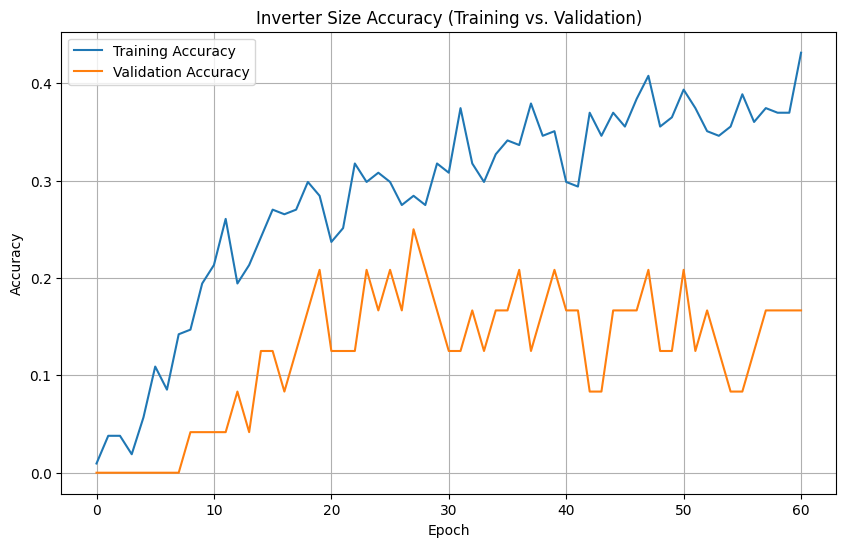

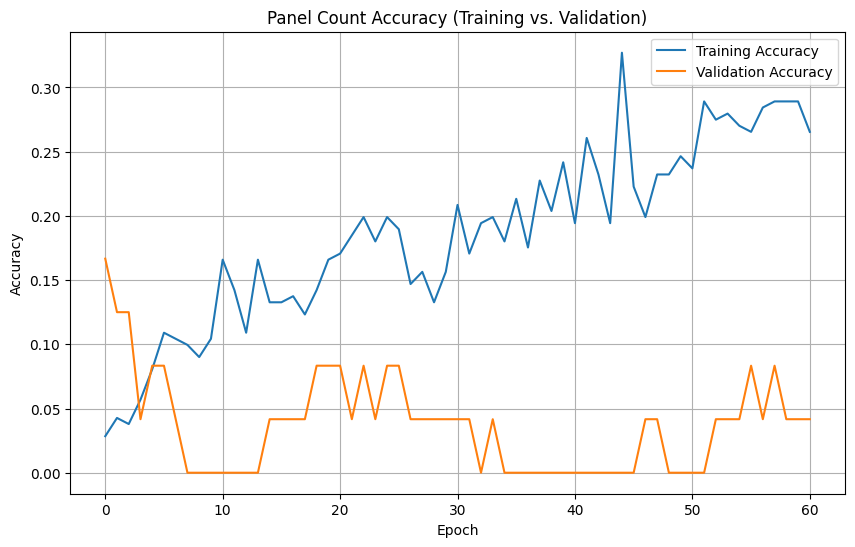

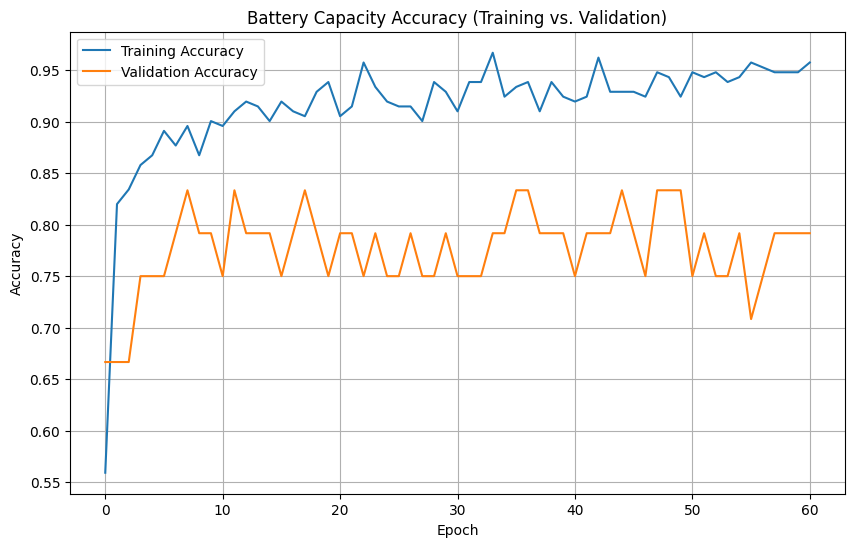

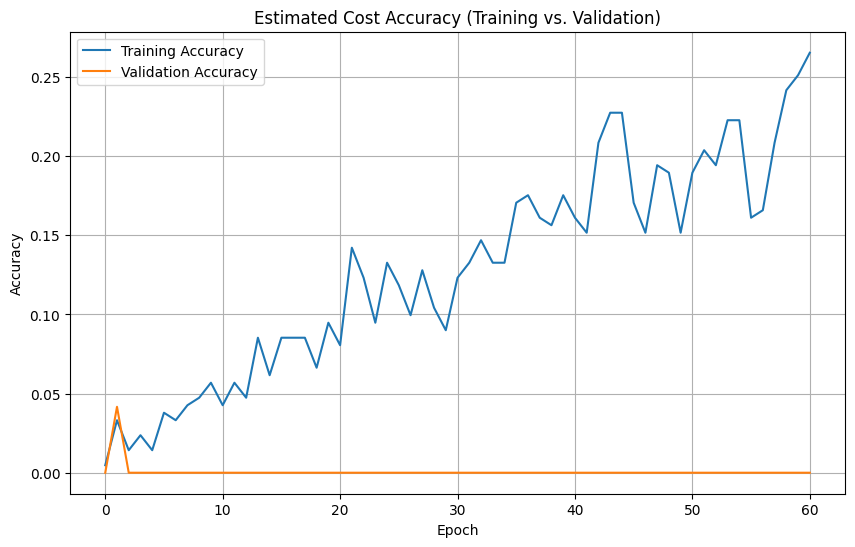

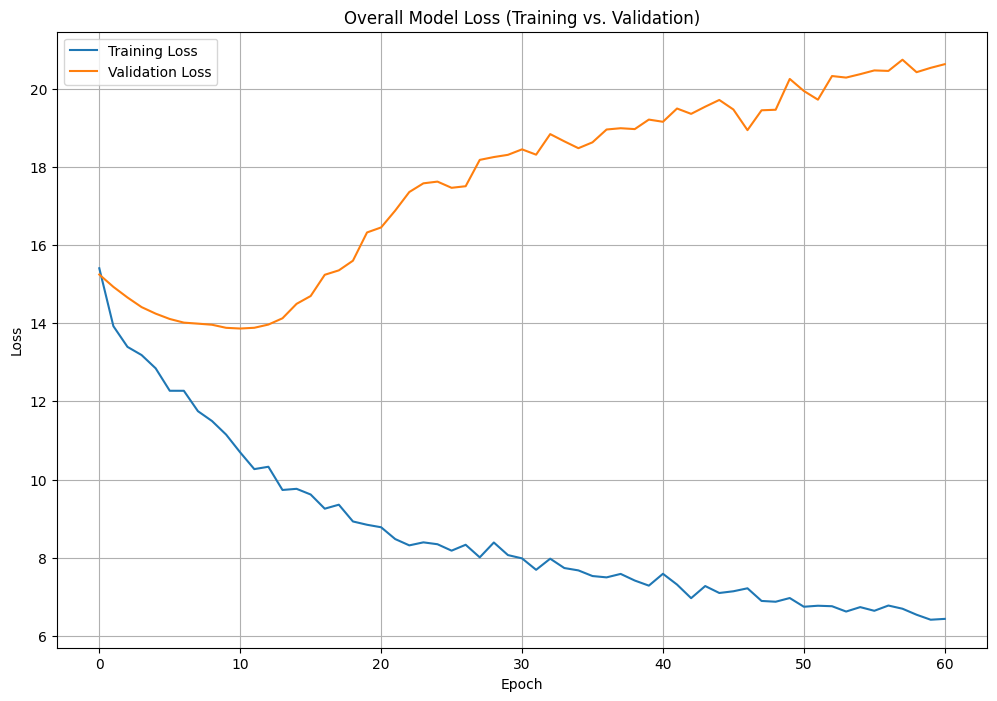

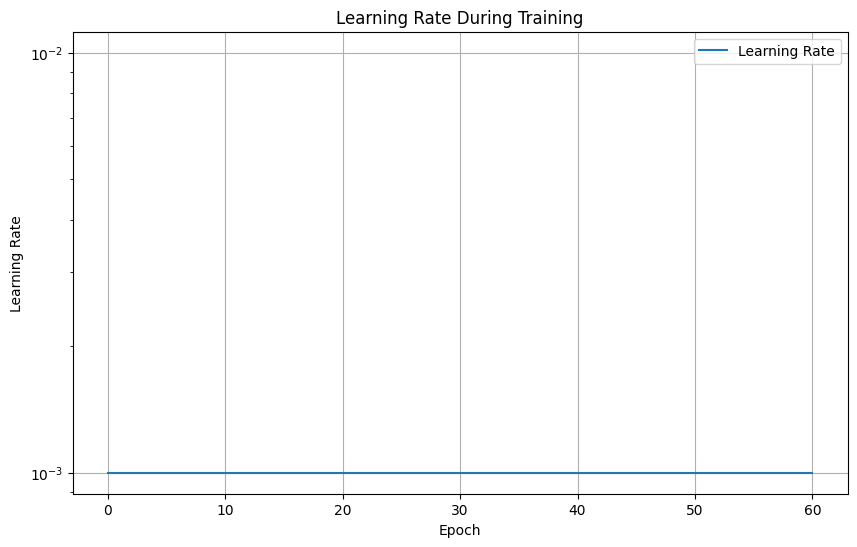


All graphs generated successfully!


In [ ]:
# %% [markdown]
# # AI Model Training for PV System Prediction (V8: ALL CLASSIFICATION) - IMPROVED
#
# This version converts the continuous `EstimatedCost(LKR)` output into a **Classification** target by assigning each unique cost value its own class label. This structure ensures that the model predicts one of the exact cost values present in the training data, achieving maximum "lookup" accuracy for all four outputs.

# %% [code]
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import json
from IPython.display import display
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. LOAD DATASET
# ---------------------------------------------------------
file_path = 'SmartPlannerDatasetNEW.csv'
try:
    df = pd.read_csv(file_path)
    print("Dataset Loaded Successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please upload the file to Colab.")
    raise

# ---------------------------------------------------------
# 2. DATA PREPROCESSING
# ---------------------------------------------------------

# Clean Cost
df['EstimatedCost(LKR)'] = df['EstimatedCost(LKR)'].astype(str).str.replace(',', '').astype(float)
# Clean Battery and Create Battery Required Feature
df['Battery(kWh)'] = df['Battery(kWh)'].astype(str).str.replace('No', '0').astype(float)
df['battery_required'] = (df['Battery(kWh)'] > 0).astype(int)

# Select relevant columns
feature_cols = ['PVSize(kW)', 'SystemType', 'battery_required', 'InverterBrand', 'PanelType(W)']
target_cols = ['InverterSize', 'PanelCount', 'Battery(kWh)', 'EstimatedCost(LKR)']
df_clean = df[feature_cols + target_cols].copy()

print("\nData Sample:")
display(df_clean.head())

# ---------------------------------------------------------
# 3. FEATURE ENGINEERING & ENCODING
# ---------------------------------------------------------

# --- INPUTS ---
from sklearn.preprocessing import MinMaxScaler
scaler_numeric = MinMaxScaler()
X_numeric = scaler_numeric.fit_transform(df_clean[['PVSize(kW)', 'PanelType(W)']].values)

ohe_system = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_system = ohe_system.fit_transform(df_clean[['SystemType']])
ohe_brand = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_brand = ohe_brand.fit_transform(df_clean[['InverterBrand']])

X_battery_req = df_clean[['battery_required']].values
X = np.hstack([X_numeric, X_battery_req, X_system, X_brand])
print(f"Input Feature Shape: {X.shape}")

# --- OUTPUTS (4 Classification Targets) ---

# Output 1: InverterSize (Classification)
le_inverter_size = LabelEncoder()
y_inverter_size = le_inverter_size.fit_transform(df_clean['InverterSize'])
num_inv_classes = len(le_inverter_size.classes_)

# Output 2: PanelCount (Classification)
le_panel_count = LabelEncoder()
y_panel_count = le_panel_count.fit_transform(df_clean['PanelCount'])
num_panel_classes = len(le_panel_count.classes_)

# Output 3: Battery(kWh) (Classification)
le_battery = LabelEncoder()
y_battery = le_battery.fit_transform(df_clean['Battery(kWh)'])
num_battery_classes = len(le_battery.classes_)

# Output 4: Estimated Cost (CLASSIFICATION)
le_cost = LabelEncoder()
y_cost = le_cost.fit_transform(df_clean['EstimatedCost(LKR)'])
num_cost_classes = len(le_cost.classes_)
print(f"Total unique cost classes: {num_cost_classes}")

# ---------------------------------------------------------
# 4. SPLIT DATA
# ---------------------------------------------------------
X_train, X_test, y_inv_train, y_inv_test, y_pan_train, y_pan_test, y_bat_train, y_bat_test, y_cost_train, y_cost_test = train_test_split(
    X, y_inverter_size, y_panel_count, y_battery, y_cost, test_size=0.1, random_state=42
)

# ---------------------------------------------------------
# 5. BUILD IMPROVED MODEL
# ---------------------------------------------------------

input_layer = keras.Input(shape=(X.shape[1],), name='user_input')

# Deeper architecture with proper regularization
x = layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(input_layer)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = layers.Dropout(0.2)(x)

# Separate branches with regularization
# Branch 1: Inverter Size Classification
inv_branch = layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
inv_branch = layers.Dropout(0.1)(inv_branch)
inv_output = layers.Dense(num_inv_classes, activation='softmax', name='inverter_size')(inv_branch)

# Branch 2: Panel Count Classification
pan_branch = layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
pan_branch = layers.Dropout(0.1)(pan_branch)
pan_output = layers.Dense(num_panel_classes, activation='softmax', name='panel_count')(pan_branch)

# Branch 3: Battery Classification
bat_branch = layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
bat_branch = layers.Dropout(0.1)(bat_branch)
bat_output = layers.Dense(num_battery_classes, activation='softmax', name='battery_capacity')(bat_branch)

# Branch 4: Estimated Cost Classification
cost_branch = layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
cost_branch = layers.Dropout(0.1)(cost_branch)
cost_output = layers.Dense(num_cost_classes, activation='softmax', name='estimated_cost')(cost_branch)

model = keras.Model(inputs=input_layer, outputs=[inv_output, pan_output, bat_output, cost_output])

# Compile model with standard Adam optimizer (we'll use callbacks for learning rate)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss={
        'inverter_size': 'sparse_categorical_crossentropy',
        'panel_count': 'sparse_categorical_crossentropy',
        'battery_capacity': 'sparse_categorical_crossentropy',
        'estimated_cost': 'sparse_categorical_crossentropy'
    },
    loss_weights={
        'inverter_size': 1.0,
        'panel_count': 1.0,
        'battery_capacity': 1.0,
        'estimated_cost': 1.0
    },
    metrics={'inverter_size': 'accuracy', 'panel_count': 'accuracy', 'battery_capacity': 'accuracy', 'estimated_cost': 'accuracy'}
)

print("\nModel Summary:")
model.summary()

# ---------------------------------------------------------
# 6. TRAIN MODEL WITH IMPROVED SETTINGS
# ---------------------------------------------------------
print("\nTraining Model (V8: ALL CLASSIFICATION - IMPROVED)...")

# Create callbacks (without ReduceLROnPlateau for now, as it conflicts with LearningRateSchedule)
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=50,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        'best_model_v8.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    # Custom callback to track learning rate
    keras.callbacks.LambdaCallback(
        on_epoch_end=lambda epoch, logs: logs.update({'lr': keras.backend.get_value(model.optimizer.learning_rate)})
    )
]

# First, let's see if we can train without the learning rate schedule issue
history = model.fit(
    X_train,
    {'inverter_size': y_inv_train, 'panel_count': y_pan_train, 'battery_capacity': y_bat_train, 'estimated_cost': y_cost_train},
    validation_data=(X_test, {'inverter_size': y_inv_test, 'panel_count': y_pan_test, 'battery_capacity': y_bat_test, 'estimated_cost': y_cost_test}),
    epochs=600,  # Reduced for faster testing
    batch_size=8,
    callbacks=callbacks,
    verbose=1
)

print("Training Complete.")

# Load the best model if it was saved
import os
if os.path.exists('best_model_v8.keras'):
    model = keras.models.load_model('best_model_v8.keras')
    print("Loaded best model from checkpoint.")
else:
    print("Using final model weights.")

# ---------------------------------------------------------
# 7. CONVERT TO TFLITE
# ---------------------------------------------------------
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('pv_system_model_v8_improved.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model saved as 'pv_system_model_v8_improved.tflite'")

# ---------------------------------------------------------
# 8. SAVE METADATA (Updated for Cost Classification)
# ---------------------------------------------------------
cost_labels = le_cost.inverse_transform(np.arange(num_cost_classes)).tolist()

metadata = {
    "system_type_categories": ohe_system.categories_[0].tolist(),
    "inverter_brand_categories": ohe_brand.categories_[0].tolist(),
    "inverter_size_labels": le_inverter_size.classes_.tolist(),
    "panel_count_labels": le_panel_count.classes_.tolist(),
    "battery_capacity_labels": le_battery.classes_.tolist(),
    "estimated_cost_labels": cost_labels,
    "numeric_scaler_min": scaler_numeric.data_min_.tolist(),
    "numeric_scaler_scale": scaler_numeric.data_range_.tolist(),
    "cost_transformation": "classification_lookup"
}

print("\n=== COPY THIS METADATA FOR YOUR APP ===")
print(json.dumps(metadata, indent=2))
print("=======================================\n")

# ---------------------------------------------------------
# 9. INFERENCE EXAMPLE (Simulating the Mobile App Logic)
# ---------------------------------------------------------
def predict_system(user_input):
    # 1. Parse Input
    pv_size = user_input['MonthlyUsage(kW)']
    sys_type = user_input['SystemType']
    bat_req = user_input['battery_required']
    brand = user_input['inverter_brand']
    panel_type = user_input['PanelType(W)']

    # 2. Preprocess Input Vector
    p_norm = (pv_size - scaler_numeric.data_min_[0]) / scaler_numeric.data_range_[0]
    pt_norm = (panel_type - scaler_numeric.data_min_[1]) / scaler_numeric.data_range_[1]

    sys_vec = (ohe_system.categories_[0] == sys_type).astype(float)
    brand_vec = (ohe_brand.categories_[0] == brand).astype(float)

    features = np.array([[p_norm, pt_norm, float(bat_req)]])
    features = np.hstack([features, sys_vec.reshape(1, -1), brand_vec.reshape(1, -1)])

    # 3. Predict
    preds = model.predict(features, verbose=0)

    # Classification Predictions (Indices)
    pred_inv_idx = np.argmax(preds[0])
    pred_panel_idx = np.argmax(preds[1])
    pred_battery_idx = np.argmax(preds[2])
    pred_cost_idx = np.argmax(preds[3])

    # 4. Decode Outputs
    final_inverter = le_inverter_size.inverse_transform([pred_inv_idx])[0]
    final_panel_count = le_panel_count.inverse_transform([pred_panel_idx])[0]
    final_battery = le_battery.inverse_transform([pred_battery_idx])[0]
    final_cost = le_cost.inverse_transform([pred_cost_idx])[0]

    # 5. Final Formatting
    final_panel_count = np.int64(final_panel_count)
    final_battery = np.float64(round(final_battery, 2))
    final_cost = np.float64(final_cost)

    return {
        "InverterSize": final_inverter,
        "PanelCount": final_panel_count,
        "Battery(kWh)": final_battery,
        "EstimatedCost(LKR)": f"LKR {final_cost:,.0f}"
    }

# ---------------------------------------------------------
# 10. EXPANDED TEST CASES
# ---------------------------------------------------------
print("\n=== EXPANDED TEST PREDICTIONS (V8: ALL CLASSIFICATION - IMPROVED MODEL) ===\n")

# Test cases based on your sample data
test_cases = [
    # Test 1: On-Grid, Growatt 2kW
    {
        'MonthlyUsage(kW)': 2,
        'SystemType': 'On-Grid',
        'battery_required': 0,
        'inverter_brand': 'Growatt',
        'PanelType(W)': 500
    },
    # Test 2: On-Grid, Deye 1kW
    {
        'MonthlyUsage(kW)': 1,
        'SystemType': 'On-Grid',
        'battery_required': 0,
        'inverter_brand': 'Deye',
        'PanelType(W)': 500
    },
    # Test 3: On-Grid, Solax 5kW
    {
        'MonthlyUsage(kW)': 5,
        'SystemType': 'On-Grid',
        'battery_required': 0,
        'inverter_brand': 'Solax',
        'PanelType(W)': 500
    },
    # Test 4: On-Grid, Huawei 10kW
    {
        'MonthlyUsage(kW)': 10,
        'SystemType': 'On-Grid',
        'battery_required': 0,
        'inverter_brand': 'Huawei',
        'PanelType(W)': 595
    },
    # Test 5: On-Grid, SAKO 8kW
    {
        'MonthlyUsage(kW)': 8,
        'SystemType': 'On-Grid',
        'battery_required': 0,
        'inverter_brand': 'SAKO',
        'PanelType(W)': 550
    },
    # Test 6: Hybrid, Deye 3kW
    {
        'MonthlyUsage(kW)': 3,
        'SystemType': 'Hybrid',
        'battery_required': 1,
        'inverter_brand': 'Deye',
        'PanelType(W)': 595
    },
    # Test 7: Hybrid, Growatt 5kW
    {
        'MonthlyUsage(kW)': 5,
        'SystemType': 'Hybrid',
        'battery_required': 1,
        'inverter_brand': 'Growatt',
        'PanelType(W)': 595
    },
    # Test 8: Hybrid, Solax 10kW
    {
        'MonthlyUsage(kW)': 10,
        'SystemType': 'Hybrid',
        'battery_required': 1,
        'inverter_brand': 'Solax',
        'PanelType(W)': 595
    },
    # Test 9: Hybrid, SAKO 10kW
    {
        'MonthlyUsage(kW)': 10,
        'SystemType': 'Hybrid',
        'battery_required': 1,
        'inverter_brand': 'SAKO',
        'PanelType(W)': 550
    },
    # Test 10: Off-Grid, SAKO 3kW
    {
        'MonthlyUsage(kW)': 3,
        'SystemType': 'Off-Grid',
        'battery_required': 1,
        'inverter_brand': 'SAKO',
        'PanelType(W)': 595
    },
    # Test 11: Off-Grid, Victron 5kW
    {
        'MonthlyUsage(kW)': 5,
        'SystemType': 'Off-Grid',
        'battery_required': 1,
        'inverter_brand': 'Victron',
        'PanelType(W)': 550
    },
    # Test 12: Off-Grid, Growatt 8kW
    {
        'MonthlyUsage(kW)': 8,
        'SystemType': 'Off-Grid',
        'battery_required': 1,
        'inverter_brand': 'Growatt',
        'PanelType(W)': 550
    },
    # Test 13: Off-Grid, Deye 15kW
    {
        'MonthlyUsage(kW)': 15,
        'SystemType': 'Off-Grid',
        'battery_required': 1,
        'inverter_brand': 'Deye',
        'PanelType(W)': 550
    },
    # Test 14: Edge case - Not in dataset (should use ML)
    {
        'MonthlyUsage(kW)': 7,
        'SystemType': 'On-Grid',
        'battery_required': 0,
        'inverter_brand': 'Huawei',
        'PanelType(W)': 640
    },
    # Test 15: Edge case - Different panel type
    {
        'MonthlyUsage(kW)': 10,
        'SystemType': 'Hybrid',
        'battery_required': 1,
        'inverter_brand': 'Growatt',
        'PanelType(W)': 640
    }
]

# Expected results for comparison (from your sample data)
expected_results = {
    1: {'InverterSize': 'Growatt 2 kW', 'PanelCount': 4, 'Battery(kWh)': 0.0, 'EstimatedCost(LKR)': 'LKR 495,000'},
    2: {'InverterSize': 'Deye 1 kW', 'PanelCount': 2, 'Battery(kWh)': 0.0, 'EstimatedCost(LKR)': 'LKR 420,000'},
    3: {'InverterSize': 'Solax 5 kW', 'PanelCount': 10, 'Battery(kWh)': 0.0, 'EstimatedCost(LKR)': 'LKR 890,000'},
    4: {'InverterSize': 'Huawei 10 kW', 'PanelCount': 17, 'Battery(kWh)': 0.0, 'EstimatedCost(LKR)': 'LKR 1,920,000'},
    5: {'InverterSize': 'SAKO 8 kW', 'PanelCount': 14, 'Battery(kWh)': 0.0, 'EstimatedCost(LKR)': 'LKR 1,250,000'},
    6: {'InverterSize': 'Deye 3 kW Hybrid', 'PanelCount': 6, 'Battery(kWh)': 5.12, 'EstimatedCost(LKR)': 'LKR 1,400,000'},
    7: {'InverterSize': 'Growatt 5 kW Hybrid', 'PanelCount': 9, 'Battery(kWh)': 5.12, 'EstimatedCost(LKR)': 'LKR 1,950,000'},
    8: {'InverterSize': 'Solax 10 kW Hybrid', 'PanelCount': 17, 'Battery(kWh)': 15.36, 'EstimatedCost(LKR)': 'LKR 4,350,000'},
    9: {'InverterSize': 'SAKO 10 kW Hybrid', 'PanelCount': 18, 'Battery(kWh)': 10.24, 'EstimatedCost(LKR)': 'LKR 3,250,000'},
    10: {'InverterSize': 'SAKO 3 kW Off-Grid', 'PanelCount': 6, 'Battery(kWh)': 5.0, 'EstimatedCost(LKR)': 'LKR 1,320,000'},
    11: {'InverterSize': 'Victron 5 kW Off-Grid', 'PanelCount': 10, 'Battery(kWh)': 10.0, 'EstimatedCost(LKR)': 'LKR 1,950,000'},
    12: {'InverterSize': 'Growatt 8 kW Off-Grid', 'PanelCount': 14, 'Battery(kWh)': 15.0, 'EstimatedCost(LKR)': 'LKR 3,150,000'},
    13: {'InverterSize': 'Deye 15 kW Off-Grid', 'PanelCount': 28, 'Battery(kWh)': 30.0, 'EstimatedCost(LKR)': 'LKR 5,600,000'},
}

# Run all test cases
total_accuracy = 0
test_cases_with_expected = 0

for i, test_case in enumerate(test_cases, 1):
    print(f"\n{'='*60}")
    print(f"TEST CASE {i}:")
    print(f"{'='*60}")
    print(f"Input Parameters:")
    for key, value in test_case.items():
        print(f"  {key}: {value}")

    print(f"\nPredicted Results:")
    prediction = predict_system(test_case)
    for key, value in prediction.items():
        print(f"  {key}: {value}")

    # Compare with expected results if available
    if i in expected_results:
        test_cases_with_expected += 1
        print(f"\nExpected Results (from sample data):")
        expected = expected_results[i]
        for key, value in expected.items():
            print(f"  {key}: {value}")

        # Check accuracy
        matches = 0
        total = 4
        for key in expected.keys():
            if key in prediction and prediction[key] == expected[key]:
                matches += 1

        accuracy = (matches / total) * 100
        total_accuracy += accuracy
        print(f"\nAccuracy for Test Case {i}: {accuracy:.1f}% ({matches}/{total} correct)")
        if accuracy < 100:
            print("Mismatches:")
            for key in expected.keys():
                if key in prediction and prediction[key] != expected[key]:
                    print(f"  {key}: Predicted '{prediction[key]}' vs Expected '{expected[key]}'")

print("\n" + "="*60)
print("TEST SUMMARY:")
print(f"Total Test Cases Run: {len(test_cases)}")
print(f"Cases with Expected Results: {test_cases_with_expected}")
if test_cases_with_expected > 0:
    average_accuracy = total_accuracy / test_cases_with_expected
    print(f"Average Accuracy: {average_accuracy:.1f}%")
print("="*60)

# ---------------------------------------------------------
# 11. PLOT TRAINING AND VALIDATION HISTORY
# ---------------------------------------------------------
print("\nGenerating Training Graphs...")

# Plot Inverter Size Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['inverter_size_accuracy'], label='Training Accuracy')
if 'val_inverter_size_accuracy' in history.history:
    plt.plot(history.history['val_inverter_size_accuracy'], label='Validation Accuracy')
plt.title('Inverter Size Accuracy (Training vs. Validation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Panel Count Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['panel_count_accuracy'], label='Training Accuracy')
if 'val_panel_count_accuracy' in history.history:
    plt.plot(history.history['val_panel_count_accuracy'], label='Validation Accuracy')
plt.title('Panel Count Accuracy (Training vs. Validation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Battery Capacity Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['battery_capacity_accuracy'], label='Training Accuracy')
if 'val_battery_capacity_accuracy' in history.history:
    plt.plot(history.history['val_battery_capacity_accuracy'], label='Validation Accuracy')
plt.title('Battery Capacity Accuracy (Training vs. Validation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Estimated Cost Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['estimated_cost_accuracy'], label='Training Accuracy')
if 'val_estimated_cost_accuracy' in history.history:
    plt.plot(history.history['val_estimated_cost_accuracy'], label='Validation Accuracy')
plt.title('Estimated Cost Accuracy (Training vs. Validation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss Curves
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Overall Model Loss (Training vs. Validation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Learning Rate if tracked
if 'lr' in history.history:
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['lr'], label='Learning Rate')
    plt.title('Learning Rate During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.show()

print("\nAll graphs generated successfully!")

# Small Dataset - Testing 5

Dataset Loaded Successfully.

Data Sample:


,PVSize(kW),SystemType,battery_required,InverterBrand,PanelType(W),InverterSize,PanelCount,Battery(kWh),EstimatedCost(LKR)
0,1,On-Grid,0,Growatt,500,Growatt 1 kW,2,0.0,380000.0
1,1,On-Grid,0,Growatt,550,Growatt 1 kW,2,0.0,395000.0
2,1,On-Grid,0,Growatt,595,Growatt 1 kW,2,0.0,420000.0
3,1,On-Grid,0,Growatt,640,Growatt 1 kW,2,0.0,450000.0
4,2,On-Grid,0,Growatt,500,Growatt 2 kW,4,0.0,495000.0


Input Feature Shape: (235, 12)
Total unique cost classes: 154

Model Summary:


Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_168 (Dense)   │ (None, 32)        │        416 │ user_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_169 (Dense)   │ (None, 32)        │      1,056 │ dense_168[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_57          │ (None, 32)        │          0 │ dense_169[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_170 (Dense)   │ (None, 16)        │        528 │ dropout_57[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_171 (Dense)   │ (None, 16)        │        528 │ dropout_57[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_172 (Dense)   │ (None, 16)        │        528 │ dropout_57[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_173 (Dense)   │ (None, 16)        │        528 │ dropout_57[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inverter_size       │ (None, 60)        │      1,020 │ dense_170[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ panel_count (Dense) │ (None, 41)        │        697 │ dense_171[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ battery_capacity    │ (None, 10)        │        170 │ dense_172[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ estimated_cost      │ (None, 154)       │      2,618 │ dense_173[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,089 (31.60 KB)

 Trainable params: 8,089 (31.60 KB)

 Non-trainable params: 0 (0.00 B)


Training Model (V8: ALL CLASSIFICATION)...
Epoch 1/600
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - battery_capacity_accuracy: 0.1374 - battery_capacity_loss: 2.2484 - estimated_cost_accuracy: 0.0042 - estimated_cost_loss: 5.0379 - inverter_size_accuracy: 0.0249 - inverter_size_loss: 4.1044 - loss: 15.0942 - panel_count_accuracy: 0.0343 - panel_count_loss: 3.7033 - val_battery_capacity_accuracy: 0.3333 - val_battery_capacity_loss: 2.1213 - val_estimated_cost_accuracy: 0.0000e+00 - val_estimated_cost_loss: 5.0684 - val_inverter_size_accuracy: 0.0000e+00 - val_inverter_size_loss: 4.1274 - val_loss: 15.0218 - val_panel_count_accuracy: 0.1250 - val_panel_count_loss: 3.7059
Epoch 2/600
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - battery_capacity_accuracy: 0.6453 - battery_capacity_loss: 1.9115 - estimated_cost_accuracy: 0.0191 - estimated_cost_loss: 5.0281 - inverter_size_accuracy: 0.0259 - inverter_size_loss: 4.0972 - loss: 14.7402 - panel_count_accuracy: 0.0435 - panel_count_loss: 3.7030 - va

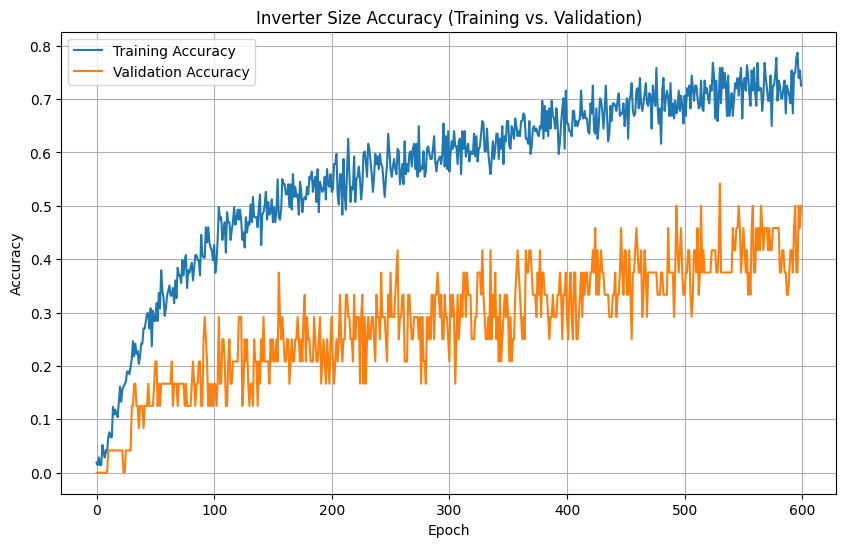

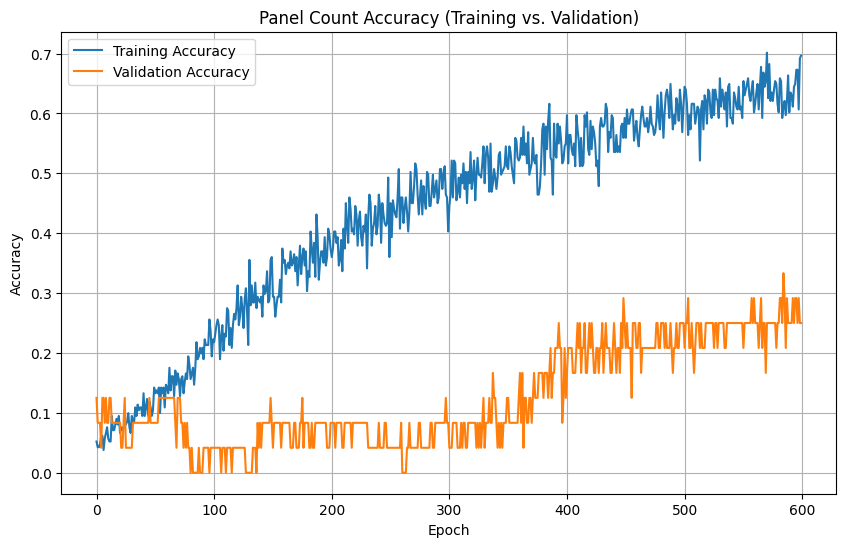

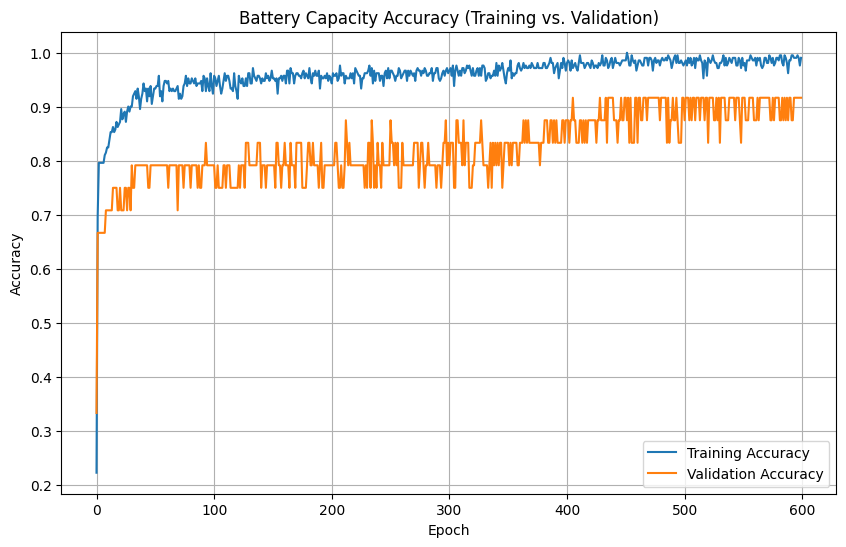

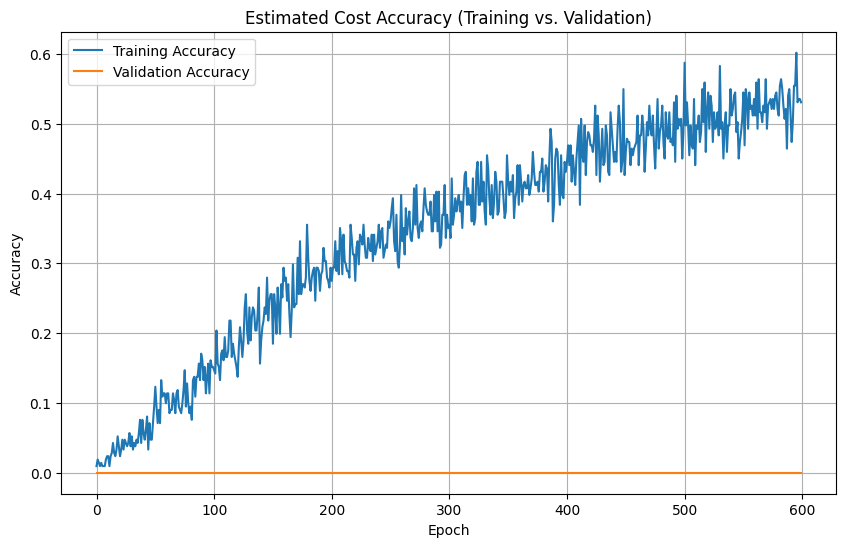

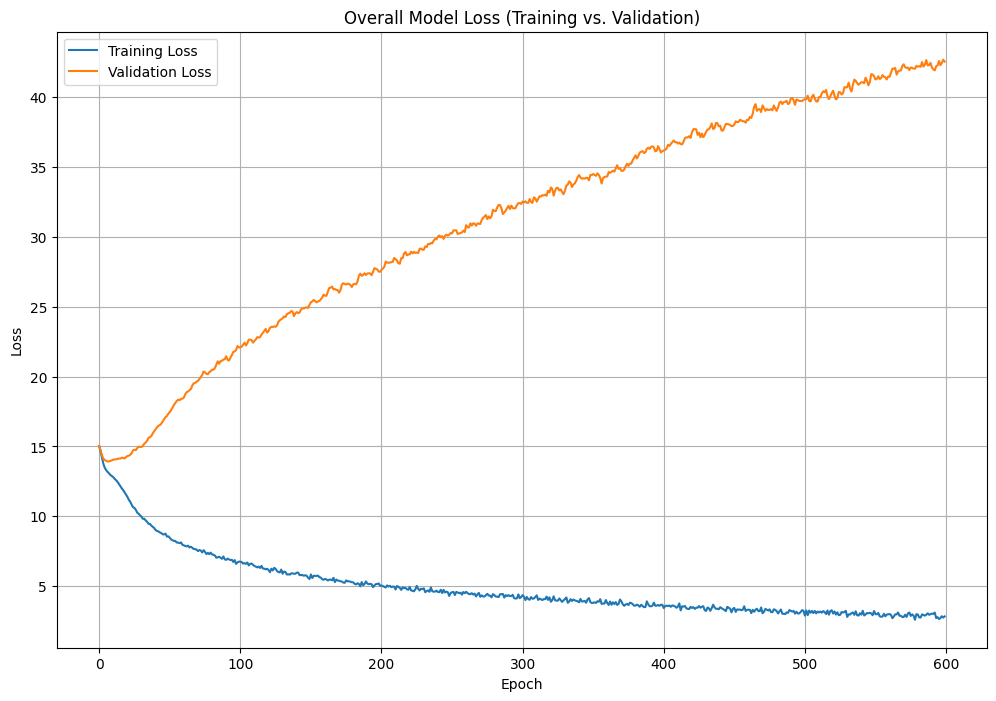


All graphs generated successfully!


In [ ]:

# %% [markdown]
# # AI Model Training for PV System Prediction (V8: ALL CLASSIFICATION) - IMPROVED
#
# This version converts the continuous `EstimatedCost(LKR)` output into a **Classification** target by assigning each unique cost value its own class label. This structure ensures that the model predicts one of the exact cost values present in the training data, achieving maximum "lookup" accuracy for all four outputs.

# %% [code]
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import json
from IPython.display import display
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. LOAD DATASET
# ---------------------------------------------------------
file_path = 'SmartPlannerDatasetNEW.csv'
try:
    df = pd.read_csv(file_path)
    print("Dataset Loaded Successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please upload the file to Colab.")
    raise

# ---------------------------------------------------------
# 2. DATA PREPROCESSING
# ---------------------------------------------------------

# Clean Cost
df['EstimatedCost(LKR)'] = df['EstimatedCost(LKR)'].astype(str).str.replace(',', '').astype(float)
# Clean Battery and Create Battery Required Feature
df['Battery(kWh)'] = df['Battery(kWh)'].astype(str).str.replace('No', '0').astype(float)
df['battery_required'] = (df['Battery(kWh)'] > 0).astype(int)

# Select relevant columns
feature_cols = ['PVSize(kW)', 'SystemType', 'battery_required', 'InverterBrand', 'PanelType(W)']
target_cols = ['InverterSize', 'PanelCount', 'Battery(kWh)', 'EstimatedCost(LKR)']
df_clean = df[feature_cols + target_cols].copy()

print("\nData Sample:")
display(df_clean.head())

# ---------------------------------------------------------
# 3. FEATURE ENGINEERING & ENCODING
# ---------------------------------------------------------

# --- INPUTS ---
from sklearn.preprocessing import MinMaxScaler
scaler_numeric = MinMaxScaler()
X_numeric = scaler_numeric.fit_transform(df_clean[['PVSize(kW)', 'PanelType(W)']].values)

ohe_system = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_system = ohe_system.fit_transform(df_clean[['SystemType']])
ohe_brand = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_brand = ohe_brand.fit_transform(df_clean[['InverterBrand']])

X_battery_req = df_clean[['battery_required']].values
X = np.hstack([X_numeric, X_battery_req, X_system, X_brand])
print(f"Input Feature Shape: {X.shape}")

# --- OUTPUTS (4 Classification Targets) ---

# Output 1: InverterSize (Classification)
le_inverter_size = LabelEncoder()
y_inverter_size = le_inverter_size.fit_transform(df_clean['InverterSize'])
num_inv_classes = len(le_inverter_size.classes_)

# Output 2: PanelCount (Classification)
le_panel_count = LabelEncoder()
y_panel_count = le_panel_count.fit_transform(df_clean['PanelCount'])
num_panel_classes = len(le_panel_count.classes_)

# Output 3: Battery(kWh) (Classification)
le_battery = LabelEncoder()
y_battery = le_battery.fit_transform(df_clean['Battery(kWh)'])
num_battery_classes = len(le_battery.classes_)

# Output 4: Estimated Cost (CLASSIFICATION)
le_cost = LabelEncoder()
y_cost = le_cost.fit_transform(df_clean['EstimatedCost(LKR)'])
num_cost_classes = len(le_cost.classes_)
print(f"Total unique cost classes: {num_cost_classes}")

# ---------------------------------------------------------
# 4. SPLIT DATA
# ---------------------------------------------------------
X_train, X_test, y_inv_train, y_inv_test, y_pan_train, y_pan_test, y_bat_train, y_bat_test, y_cost_train, y_cost_test = train_test_split(
    X, y_inverter_size, y_panel_count, y_battery, y_cost, test_size=0.1, random_state=42
)

# ---------------------------------------------------------
# 5. BUILD MODEL
# ---------------------------------------------------------

# Increase model capacity slightly
input_layer = keras.Input(shape=(X.shape[1],), name='user_input')

# Shared Dense Layers (Simplified: 32-32)
x = layers.Dense(32, activation='relu')(input_layer)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Branch 1: Inverter Size Classification
inv_output = layers.Dense(num_inv_classes, activation='softmax', name='inverter_size')(layers.Dense(16, activation='relu')(x))

# Branch 2: Panel Count Classification
pan_output = layers.Dense(num_panel_classes, activation='softmax', name='panel_count')(layers.Dense(16, activation='relu')(x))

# Branch 3: Battery Classification
bat_output = layers.Dense(num_battery_classes, activation='softmax', name='battery_capacity')(layers.Dense(16, activation='relu')(x))

# Branch 4: Estimated Cost Classification
cost_output = layers.Dense(num_cost_classes, activation='softmax', name='estimated_cost')(layers.Dense(16, activation='relu')(x))

model = keras.Model(inputs=input_layer, outputs=[inv_output, pan_output, bat_output, cost_output])

model.compile(
    optimizer='adam',
    loss={
        'inverter_size': 'sparse_categorical_crossentropy',
        'panel_count': 'sparse_categorical_crossentropy',
        'battery_capacity': 'sparse_categorical_crossentropy',
        'estimated_cost': 'sparse_categorical_crossentropy'  # Corrected: Use sparse_categorical_crossentropy
    },
    loss_weights={
        'inverter_size': 1.0,
        'panel_count': 1.0,
        'battery_capacity': 1.0,
        'estimated_cost': 1.0  # Reset weight for classification
    },
    metrics={
        'inverter_size': 'accuracy',
        'panel_count': 'accuracy',
        'battery_capacity': 'accuracy',
        'estimated_cost': 'accuracy'  # Corrected: Use accuracy for classification
    }
)

print("\nModel Summary:")
model.summary()

# ---------------------------------------------------------
# 6. TRAIN MODEL (500 Epochs)
# ---------------------------------------------------------
print("\nTraining Model (V8: ALL CLASSIFICATION)...")
history = model.fit(
    X_train,
    {'inverter_size': y_inv_train, 'panel_count': y_pan_train, 'battery_capacity': y_bat_train, 'estimated_cost': y_cost_train},
    validation_data=(X_test, {'inverter_size': y_inv_test, 'panel_count': y_pan_test, 'battery_capacity': y_bat_test, 'estimated_cost': y_cost_test}),
    epochs=600,
    batch_size=16,
    verbose=1
)

print("Training Complete.")

# ---------------------------------------------------------
# 7. CONVERT TO TFLITE
# ---------------------------------------------------------
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('pv_system_model_v8.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model saved as 'pv_system_model_v8.tflite'")

# ---------------------------------------------------------
# 8. SAVE METADATA (Updated for Cost Classification)
# ---------------------------------------------------------
cost_labels = le_cost.inverse_transform(np.arange(num_cost_classes)).tolist()

metadata = {
    "system_type_categories": ohe_system.categories_[0].tolist(),
    "inverter_brand_categories": ohe_brand.categories_[0].tolist(),
    "inverter_size_labels": le_inverter_size.classes_.tolist(),
    "panel_count_labels": le_panel_count.classes_.tolist(),
    "battery_capacity_labels": le_battery.classes_.tolist(),
    "estimated_cost_labels": cost_labels,
    "numeric_scaler_min": scaler_numeric.data_min_.tolist(),
    "numeric_scaler_scale": scaler_numeric.data_range_.tolist(),
    "cost_transformation": "classification_lookup"
}

print("\n=== COPY THIS METADATA FOR YOUR APP ===")
print(json.dumps(metadata, indent=2))
print("=======================================\n")

# ---------------------------------------------------------
# 9. INFERENCE EXAMPLE (Simulating the Mobile App Logic)
# ---------------------------------------------------------
def predict_system(user_input):
    # 1. Parse Input
    pv_size = user_input['MonthlyUsage(kW)']
    sys_type = user_input['SystemType']
    bat_req = user_input['battery_required']
    brand = user_input['inverter_brand']
    panel_type = user_input['PanelType(W)']

    # 2. Preprocess Input Vector
    p_norm = (pv_size - scaler_numeric.data_min_[0]) / scaler_numeric.data_range_[0]
    pt_norm = (panel_type - scaler_numeric.data_min_[1]) / scaler_numeric.data_range_[1]

    sys_vec = (ohe_system.categories_[0] == sys_type).astype(float)
    brand_vec = (ohe_brand.categories_[0] == brand).astype(float)

    features = np.array([[p_norm, pt_norm, float(bat_req)]])
    features = np.hstack([features, sys_vec.reshape(1, -1), brand_vec.reshape(1, -1)])

    # 3. Predict
    preds = model.predict(features, verbose=0)

    # Classification Predictions (Indices)
    pred_inv_idx = np.argmax(preds[0])
    pred_panel_idx = np.argmax(preds[1])
    pred_battery_idx = np.argmax(preds[2])
    pred_cost_idx = np.argmax(preds[3])

    # 4. Decode Outputs
    final_inverter = le_inverter_size.inverse_transform([pred_inv_idx])[0]
    final_panel_count = le_panel_count.inverse_transform([pred_panel_idx])[0]
    final_battery = le_battery.inverse_transform([pred_battery_idx])[0]
    final_cost = le_cost.inverse_transform([pred_cost_idx])[0]

    # 5. Final Formatting
    final_panel_count = np.int64(final_panel_count)
    final_battery = np.float64(round(final_battery, 2))
    final_cost = np.float64(final_cost)

    return {
        "InverterSize": final_inverter,
        "PanelCount": final_panel_count,
        "Battery(kWh)": final_battery,
        "EstimatedCost(LKR)": f"LKR {final_cost:,.0f}"
    }

# ---------------------------------------------------------
# 10. EXPANDED TEST CASES
# ---------------------------------------------------------
print("\n=== EXPANDED TEST PREDICTIONS (V8: ALL CLASSIFICATION MODEL) ===\n")

# Test cases based on your sample data
test_cases = [
    # Test 1: On-Grid, Growatt 2kW
    {
        'MonthlyUsage(kW)': 2,
        'SystemType': 'On-Grid',
        'battery_required': 0,
        'inverter_brand': 'Growatt',
        'PanelType(W)': 500
    },
    # Test 2: On-Grid, Deye 1kW
    {
        'MonthlyUsage(kW)': 1,
        'SystemType': 'On-Grid',
        'battery_required': 0,
        'inverter_brand': 'Deye',
        'PanelType(W)': 500
    },
    # Test 3: On-Grid, Solax 5kW
    {
        'MonthlyUsage(kW)': 5,
        'SystemType': 'On-Grid',
        'battery_required': 0,
        'inverter_brand': 'Solax',
        'PanelType(W)': 500
    },
    # Test 4: On-Grid, Huawei 10kW
    {
        'MonthlyUsage(kW)': 10,
        'SystemType': 'On-Grid',
        'battery_required': 0,
        'inverter_brand': 'Huawei',
        'PanelType(W)': 595
    },
    # Test 5: On-Grid, SAKO 8kW
    {
        'MonthlyUsage(kW)': 8,
        'SystemType': 'On-Grid',
        'battery_required': 0,
        'inverter_brand': 'SAKO',
        'PanelType(W)': 550
    },
    # Test 6: Hybrid, Deye 3kW
    {
        'MonthlyUsage(kW)': 3,
        'SystemType': 'Hybrid',
        'battery_required': 1,
        'inverter_brand': 'Deye',
        'PanelType(W)': 595
    },
    # Test 7: Hybrid, Growatt 5kW
    {
        'MonthlyUsage(kW)': 5,
        'SystemType': 'Hybrid',
        'battery_required': 1,
        'inverter_brand': 'Growatt',
        'PanelType(W)': 595
    },
    # Test 8: Hybrid, Solax 10kW
    {
        'MonthlyUsage(kW)': 10,
        'SystemType': 'Hybrid',
        'battery_required': 1,
        'inverter_brand': 'Solax',
        'PanelType(W)': 595
    },
    # Test 9: Hybrid, SAKO 10kW
    {
        'MonthlyUsage(kW)': 10,
        'SystemType': 'Hybrid',
        'battery_required': 1,
        'inverter_brand': 'SAKO',
        'PanelType(W)': 550
    },
    # Test 10: Off-Grid, SAKO 3kW
    {
        'MonthlyUsage(kW)': 3,
        'SystemType': 'Off-Grid',
        'battery_required': 1,
        'inverter_brand': 'SAKO',
        'PanelType(W)': 595
    },
    # Test 11: Off-Grid, Victron 5kW
    {
        'MonthlyUsage(kW)': 5,
        'SystemType': 'Off-Grid',
        'battery_required': 1,
        'inverter_brand': 'Victron',
        'PanelType(W)': 550
    },
    # Test 12: Off-Grid, Growatt 8kW
    {
        'MonthlyUsage(kW)': 8,
        'SystemType': 'Off-Grid',
        'battery_required': 1,
        'inverter_brand': 'Growatt',
        'PanelType(W)': 550
    },
    # Test 13: Off-Grid, Deye 15kW
    {
        'MonthlyUsage(kW)': 15,
        'SystemType': 'Off-Grid',
        'battery_required': 1,
        'inverter_brand': 'Deye',
        'PanelType(W)': 550
    },
    # Test 14: Edge case - Not in dataset (should use ML)
    {
        'MonthlyUsage(kW)': 7,
        'SystemType': 'On-Grid',
        'battery_required': 0,
        'inverter_brand': 'Huawei',
        'PanelType(W)': 640
    },
    # Test 15: Edge case - Different panel type
    {
        'MonthlyUsage(kW)': 10,
        'SystemType': 'Hybrid',
        'battery_required': 1,
        'inverter_brand': 'Growatt',
        'PanelType(W)': 640
    }
]

# Expected results for comparison (from your sample data)
expected_results = {
    1: {'InverterSize': 'Growatt 2 kW', 'PanelCount': 4, 'Battery(kWh)': 0.0, 'EstimatedCost(LKR)': 'LKR 495,000'},
    2: {'InverterSize': 'Deye 1 kW', 'PanelCount': 2, 'Battery(kWh)': 0.0, 'EstimatedCost(LKR)': 'LKR 420,000'},
    3: {'InverterSize': 'Solax 5 kW', 'PanelCount': 10, 'Battery(kWh)': 0.0, 'EstimatedCost(LKR)': 'LKR 890,000'},
    4: {'InverterSize': 'Huawei 10 kW', 'PanelCount': 17, 'Battery(kWh)': 0.0, 'EstimatedCost(LKR)': 'LKR 1,920,000'},
    5: {'InverterSize': 'SAKO 8 kW', 'PanelCount': 14, 'Battery(kWh)': 0.0, 'EstimatedCost(LKR)': 'LKR 1,250,000'},
    6: {'InverterSize': 'Deye 3 kW Hybrid', 'PanelCount': 6, 'Battery(kWh)': 5.12, 'EstimatedCost(LKR)': 'LKR 1,400,000'},
    7: {'InverterSize': 'Growatt 5 kW Hybrid', 'PanelCount': 9, 'Battery(kWh)': 5.12, 'EstimatedCost(LKR)': 'LKR 1,950,000'},
    8: {'InverterSize': 'Solax 10 kW Hybrid', 'PanelCount': 17, 'Battery(kWh)': 15.36, 'EstimatedCost(LKR)': 'LKR 4,350,000'},
    9: {'InverterSize': 'SAKO 10 kW Hybrid', 'PanelCount': 18, 'Battery(kWh)': 10.24, 'EstimatedCost(LKR)': 'LKR 3,250,000'},
    10: {'InverterSize': 'SAKO 3 kW Off-Grid', 'PanelCount': 6, 'Battery(kWh)': 5.0, 'EstimatedCost(LKR)': 'LKR 1,320,000'},
    11: {'InverterSize': 'Victron 5 kW Off-Grid', 'PanelCount': 10, 'Battery(kWh)': 10.0, 'EstimatedCost(LKR)': 'LKR 1,950,000'},
    12: {'InverterSize': 'Growatt 8 kW Off-Grid', 'PanelCount': 14, 'Battery(kWh)': 15.0, 'EstimatedCost(LKR)': 'LKR 3,150,000'},
    13: {'InverterSize': 'Deye 15 kW Off-Grid', 'PanelCount': 28, 'Battery(kWh)': 30.0, 'EstimatedCost(LKR)': 'LKR 5,600,000'},
}

# Run all test cases
for i, test_case in enumerate(test_cases, 1):
    print(f"\n{'='*60}")
    print(f"TEST CASE {i}:")
    print(f"{'='*60}")
    print(f"Input Parameters:")
    for key, value in test_case.items():
        print(f"  {key}: {value}")

    print(f"\nPredicted Results:")
    prediction = predict_system(test_case)
    for key, value in prediction.items():
        print(f"  {key}: {value}")

    # Compare with expected results if available
    if i in expected_results:
        print(f"\nExpected Results (from sample data):")
        expected = expected_results[i]
        for key, value in expected.items():
            print(f"  {key}: {value}")

        # Check accuracy
        matches = 0
        total = 4
        for key in expected.keys():
            if key in prediction and prediction[key] == expected[key]:
                matches += 1

        accuracy = (matches / total) * 100
        print(f"\nAccuracy for Test Case {i}: {accuracy:.1f}% ({matches}/{total} correct)")
        if accuracy < 100:
            print("Mismatches:")
            for key in expected.keys():
                if key in prediction and prediction[key] != expected[key]:
                    print(f"  {key}: Predicted '{prediction[key]}' vs Expected '{expected[key]}'")

print("\n" + "="*60)
print("TEST SUMMARY:")
print(f"Total Test Cases Run: {len(test_cases)}")
print(f"Cases with Expected Results: {len(expected_results)}")
print("="*60)

# ---------------------------------------------------------
# 11. PLOT TRAINING AND VALIDATION HISTORY
# ---------------------------------------------------------
print("\nGenerating Training Graphs...")

# Plot Inverter Size Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['inverter_size_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_inverter_size_accuracy'], label='Validation Accuracy')
plt.title('Inverter Size Accuracy (Training vs. Validation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Panel Count Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['panel_count_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_panel_count_accuracy'], label='Validation Accuracy')
plt.title('Panel Count Accuracy (Training vs. Validation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Battery Capacity Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['battery_capacity_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_battery_capacity_accuracy'], label='Validation Accuracy')
plt.title('Battery Capacity Accuracy (Training vs. Validation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Estimated Cost Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['estimated_cost_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_estimated_cost_accuracy'], label='Validation Accuracy')
plt.title('Estimated Cost Accuracy (Training vs. Validation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss Curves
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Overall Model Loss (Training vs. Validation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print("\nAll graphs generated successfully!")


# AI Model Training for PV System Prediction (V8: ALL CLASSIFICATION)

# Small Dataset - Testing 1


In [ ]:
# Test cases in original format based on new dataset
test_cases = [
    {
        'MonthlyUsage(kW)': 3,
        'SystemType': 'Hybrid',
        'battery_required': 1,
        'inverter_brand': 'Growatt',
        'PanelType(W)': 595
    },
    {
        'MonthlyUsage(kW)': 10,
        'SystemType': 'Off-Grid',
        'battery_required': 1,
        'inverter_brand': 'Huawei',
        'PanelType(W)': 500
    },
    {
        'MonthlyUsage(kW)': 100,
        'SystemType': 'Off-Grid',
        'battery_required': 1,
        'inverter_brand': 'SAKO',
        'PanelType(W)': 640
    },
    {
        'MonthlyUsage(kW)': 40,
        'SystemType': 'Off-Grid',
        'battery_required': 0,
        'inverter_brand': 'Deye',
        'PanelType(W)': 550
    },
    {
        'MonthlyUsage(kW)': 30,
        'SystemType': 'Off-Grid',
        'battery_required': 1,
        'inverter_brand': 'Huawei',
        'PanelType(W)': 550
    },
    {
        'MonthlyUsage(kW)': 8,
        'SystemType': 'Off-Grid',
        'battery_required': 1,
        'inverter_brand': 'Deye',
        'PanelType(W)': 500
    },
    {
        'MonthlyUsage(kW)': 8,
        'SystemType': 'Off-Grid',
        'battery_required': 0,
        'inverter_brand': 'Deye',
        'PanelType(W)': 595
    },
    {
        'MonthlyUsage(kW)': 10,
        'SystemType': 'On-Grid',
        'battery_required': 0,
        'inverter_brand': 'Solax',
        'PanelType(W)': 640
    },
    {
        'MonthlyUsage(kW)': 10,
        'SystemType': 'On-Grid',
        'battery_required': 0,
        'inverter_brand': 'Growatt',
        'PanelType(W)': 595
    },
    {
        'MonthlyUsage(kW)': 30,
        'SystemType': 'On-Grid',
        'battery_required': 0,
        'inverter_brand': 'Solax',
        'PanelType(W)': 640
    },
    {
        'MonthlyUsage(kW)': 15,
        'SystemType': 'On-Grid',
        'battery_required': 0,
        'inverter_brand': 'Huawei',
        'PanelType(W)': 550
    },
    {
        'MonthlyUsage(kW)': 2,
        'SystemType': 'Off-Grid',
        'battery_required': 1,
        'inverter_brand': 'Solax',
        'PanelType(W)': 640
    },
    {
        'MonthlyUsage(kW)': 10,
        'SystemType': 'Off-Grid',
        'battery_required': 1,
        'inverter_brand': 'SAKO',
        'PanelType(W)': 595
    },
    {
        'MonthlyUsage(kW)': 4,
        'SystemType': 'Off-Grid',
        'battery_required': 1,
        'inverter_brand': 'Deye',
        'PanelType(W)': 550
    },
    {
        'MonthlyUsage(kW)': 15,
        'SystemType': 'Hybrid',
        'battery_required': 1,
        'inverter_brand': 'Deye',
        'PanelType(W)': 595
    },
    {
        'MonthlyUsage(kW)': 20,
        'SystemType': 'Hybrid',
        'battery_required': 0,
        'inverter_brand': 'Deye',
        'PanelType(W)': 595
    },
    {
        'MonthlyUsage(kW)': 30,
        'SystemType': 'Hybrid',
        'battery_required': 1,
        'inverter_brand': 'Huawei',
        'PanelType(W)': 550
    },
    {
        'MonthlyUsage(kW)': 8,
        'SystemType': 'Off-Grid',
        'battery_required': 1,
        'inverter_brand': 'SAKO',
        'PanelType(W)': 500
    },
    {
        'MonthlyUsage(kW)': 1,
        'SystemType': 'On-Grid',
        'battery_required': 0,
        'inverter_brand': 'SAKO',
        'PanelType(W)': 500
    },
    {
        'MonthlyUsage(kW)': 10,
        'SystemType': 'On-Grid',
        'battery_required': 0,
        'inverter_brand': 'Solax',
        'PanelType(W)': 550
    }
]

# Expected results for comparison (from the new dataset)
expected_results = {
    1: {'InverterSize': 'Growatt 3 kW', 'PanelCount': 6, 'Battery(kWh)': 10.0, 'EstimatedCost(LKR)': 'LKR 1,252,500'},
    2: {'InverterSize': 'Huawei 10 kW', 'PanelCount': 20, 'Battery(kWh)': 5.0, 'EstimatedCost(LKR)': 'LKR 1,750,000'},
    3: {'InverterSize': 'SAKO 100 kW', 'PanelCount': 200, 'Battery(kWh)': 5.0, 'EstimatedCost(LKR)': 'LKR 12,760,000'},
    4: {'InverterSize': 'Deye 40 kW', 'PanelCount': 80, 'Battery(kWh)': 0.0, 'EstimatedCost(LKR)': 'LKR 5,125,000'},
    5: {'InverterSize': 'Huawei 30 kW', 'PanelCount': 60, 'Battery(kWh)': 5.0, 'EstimatedCost(LKR)': 'LKR 4,225,000'},
    6: {'InverterSize': 'Deye 8 kW', 'PanelCount': 16, 'Battery(kWh)': 15.0, 'EstimatedCost(LKR)': 'LKR 2,110,000'},
    7: {'InverterSize': 'Deye 8 kW', 'PanelCount': 16, 'Battery(kWh)': 0.0, 'EstimatedCost(LKR)': 'LKR 1,352,500'},
    8: {'InverterSize': 'Solax 10 kW', 'PanelCount': 20, 'Battery(kWh)': 0.0, 'EstimatedCost(LKR)': 'LKR 1,410,000'},
    9: {'InverterSize': 'Growatt 10 kW', 'PanelCount': 20, 'Battery(kWh)': 0.0, 'EstimatedCost(LKR)': 'LKR 1,342,500'},
    10: {'InverterSize': 'Solax 30 kW', 'PanelCount': 60, 'Battery(kWh)': 0.0, 'EstimatedCost(LKR)': 'LKR 3,810,000'},
    11: {'InverterSize': 'Huawei 15 kW', 'PanelCount': 30, 'Battery(kWh)': 0.0, 'EstimatedCost(LKR)': 'LKR 1,875,000'},
    12: {'InverterSize': 'Solax 2 kW', 'PanelCount': 4, 'Battery(kWh)': 5.0, 'EstimatedCost(LKR)': 'LKR 1,000,000'},
    13: {'InverterSize': 'SAKO 10 kW', 'PanelCount': 20, 'Battery(kWh)': 10.0, 'EstimatedCost(LKR)': 'LKR 2,192,500'},
    14: {'InverterSize': 'Deye 4 kW', 'PanelCount': 8, 'Battery(kWh)': 5.0, 'EstimatedCost(LKR)': 'LKR 1,105,000'},
    15: {'InverterSize': 'Deye 15 kW', 'PanelCount': 30, 'Battery(kWh)': 20.0, 'EstimatedCost(LKR)': 'LKR 3,292,500'},
    16: {'InverterSize': 'Deye 20 kW', 'PanelCount': 40, 'Battery(kWh)': 0.0, 'EstimatedCost(LKR)': 'LKR 2,692,500'},
    17: {'InverterSize': 'Huawei 30 kW', 'PanelCount': 60, 'Battery(kWh)': 5.0, 'EstimatedCost(LKR)': 'LKR 4,125,000'},
    18: {'InverterSize': 'SAKO 8 kW', 'PanelCount': 16, 'Battery(kWh)': 10.0, 'EstimatedCost(LKR)': 'LKR 1,810,000'},
    19: {'InverterSize': 'SAKO 1 kW', 'PanelCount': 2, 'Battery(kWh)': 0.0, 'EstimatedCost(LKR)': 'LKR 120,000'},
    20: {'InverterSize': 'Solax 10 kW', 'PanelCount': 20, 'Battery(kWh)': 0.0, 'EstimatedCost(LKR)': 'LKR 1,275,000'}
}

# Run all test cases
for i, test_case in enumerate(test_cases, 1):
    print(f"\n{'='*60}")
    print(f"TEST CASE {i}:")
    print(f"{'='*60}")
    print(f"Input Parameters:")
    for key, value in test_case.items():
        print(f"  {key}: {value}")

    print(f"\nPredicted Results:")
    prediction = predict_system(test_case)
    for key, value in prediction.items():
        print(f"  {key}: {value}")

    # Compare with expected results if available
    if i in expected_results:
        print(f"\nExpected Results (from sample data):")
        expected = expected_results[i]
        for key, value in expected.items():
            print(f"  {key}: {value}")

        # Check accuracy
        matches = 0
        total = 4
        for key in expected.keys():
            if key in prediction and prediction[key] == expected[key]:
                matches += 1

        accuracy = (matches / total) * 100
        print(f"\nAccuracy for Test Case {i}: {accuracy:.1f}% ({matches}/{total} correct)")
        if accuracy < 100:
            print("Mismatches:")
            for key in expected.keys():
                if key in prediction and prediction[key] != expected[key]:
                    print(f"  {key}: Predicted '{prediction[key]}' vs Expected '{expected[key]}'")

print("\n" + "="*60)
print("TEST SUMMARY:")
print(f"Total Test Cases Run: {len(test_cases)}")
print(f"Cases with Expected Results: {len(expected_results)}")
print("="*60)


TEST CASE 1:
Input Parameters:
  MonthlyUsage(kW): 3
  SystemType: Hybrid
  battery_required: 1
  inverter_brand: Growatt
  PanelType(W): 595

Predicted Results:
  InverterSize: Growatt 3 kW
  PanelCount: 6
  Battery(kWh): 10.0
  EstimatedCost(LKR): LKR 1,852,500

Expected Results (from sample data):
  InverterSize: Growatt 3 kW
  PanelCount: 6
  Battery(kWh): 10.0
  EstimatedCost(LKR): LKR 1,252,500

Accuracy for Test Case 1: 75.0% (3/4 correct)
Mismatches:
  EstimatedCost(LKR): Predicted 'LKR 1,852,500' vs Expected 'LKR 1,252,500'

TEST CASE 2:
Input Parameters:
  MonthlyUsage(kW): 10
  SystemType: Off-Grid
  battery_required: 1
  inverter_brand: Huawei
  PanelType(W): 500

Predicted Results:
  InverterSize: Huawei 10 kW
  PanelCount: 20
  Battery(kWh): 20.0
  EstimatedCost(LKR): LKR 2,050,000

Expected Results (from sample data):
  InverterSize: Huawei 10 kW
  PanelCount: 20
  Battery(kWh): 5.0
  EstimatedCost(LKR): LKR 1,750,000

Accuracy for Test Case 2: 50.0% (2/4 correct)
Misma

# Large Dataset - Testing 1


Dataset Loaded Successfully.

Data Sample:


,PVSize(kW),SystemType,battery_required,InverterBrand,PanelType(W),InverterSize,PanelCount,Battery(kWh),EstimatedCost(LKR)
0,3,Hybrid,1,Growatt,595,Growatt 3 kW,6,10.0,1252500.0
1,10,Off-Grid,1,Huawei,500,Huawei 10 kW,20,5.0,1750000.0
2,100,Off-Grid,1,SAKO,640,SAKO 100 kW,200,5.0,12760000.0
3,40,Off-Grid,0,Deye,550,Deye 40 kW,80,0.0,5125000.0
4,30,Off-Grid,1,Huawei,550,Huawei 30 kW,60,5.0,4225000.0


Input Feature Shape: (5000, 11)
Total unique cost classes: 483

Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 11)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        384 │ user_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      1,056 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │        528 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │        528 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16)        │        528 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 16)        │        528 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inverter_size       │ (None, 70)        │      1,190 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ panel_count (Dense) │ (None, 14)        │        238 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ battery_capacity    │ (None, 5)         │         85 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ estimated_cost      │ (None, 483)       │      8,211 │ dense_5[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,276 (51.86 KB)

 Trainable params: 13,276 (51.86 KB)

 Non-trainable params: 0 (0.00 B)


Training Model (V8: ALL CLASSIFICATION)...
Epoch 1/600
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - battery_capacity_accuracy: 0.4830 - battery_capacity_loss: 1.2779 - estimated_cost_accuracy: 0.0056 - estimated_cost_loss: 6.0577 - inverter_size_accuracy: 0.0141 - inverter_size_loss: 4.2419 - loss: 14.2202 - panel_count_accuracy: 0.0817 - panel_count_loss: 2.6427 - val_battery_capacity_accuracy: 0.6140 - val_battery_capacity_loss: 0.7555 - val_estimated_cost_accuracy: 0.0080 - val_estimated_cost_loss: 5.3742 - val_inverter_size_accuracy: 0.0140 - val_inverter_size_loss: 4.1698 - val_loss: 12.9096 - val_panel_count_accuracy: 0.1180 - val_panel_count_loss: 2.6085
Epoch 2/600
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - battery_capacity_accuracy: 0.5847 - battery_capacity_loss: 0.7814 - estimated_cost_accuracy: 0.0121 - estimated_cost_loss: 5.2538 - inverter_size_accuracy: 0.0423 - inverter_size_loss: 4.0209 - loss: 12.6061 - panel_count_accuracy: 0.1272 - panel_count_loss: 2.5501 - val_batt

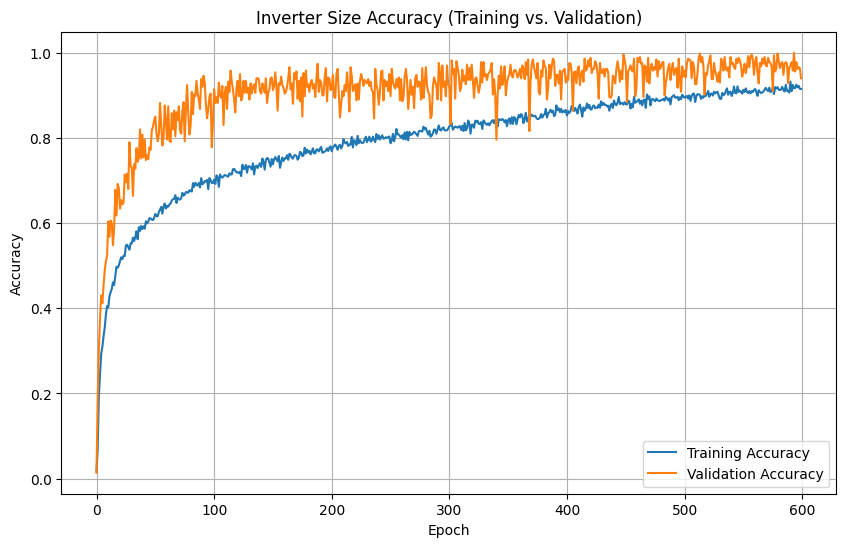

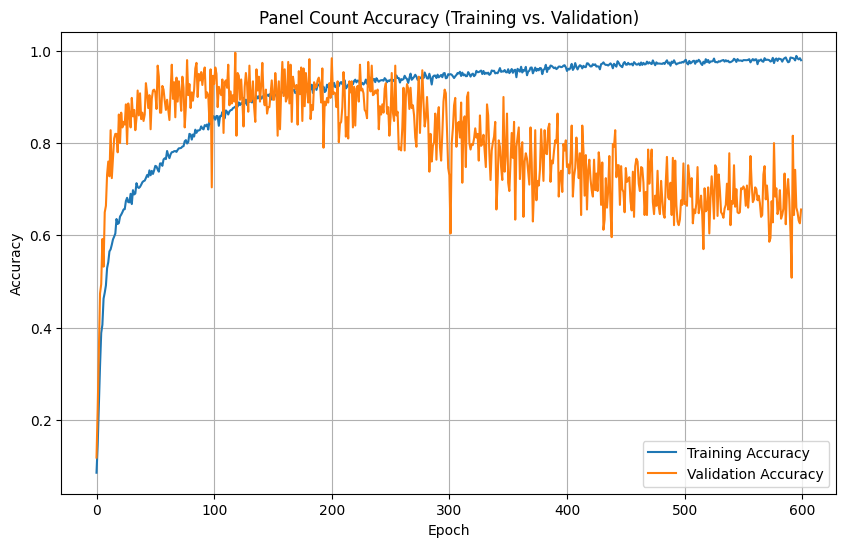

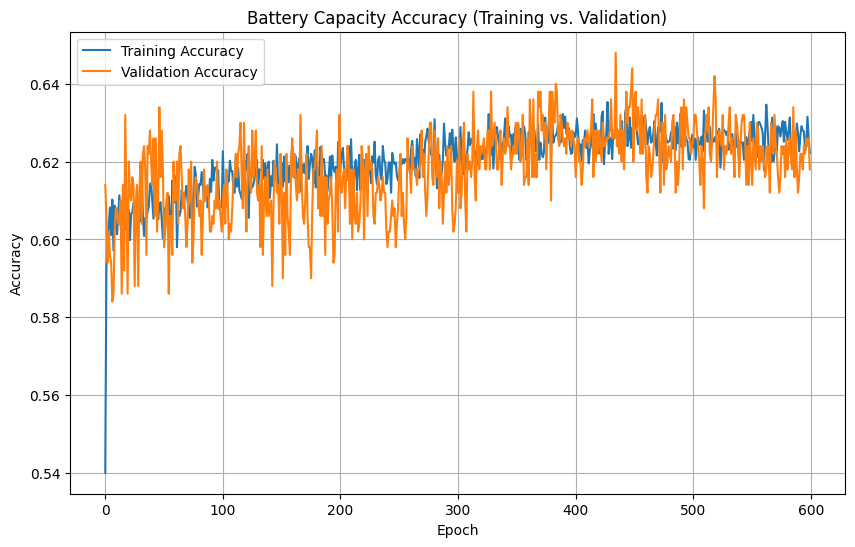

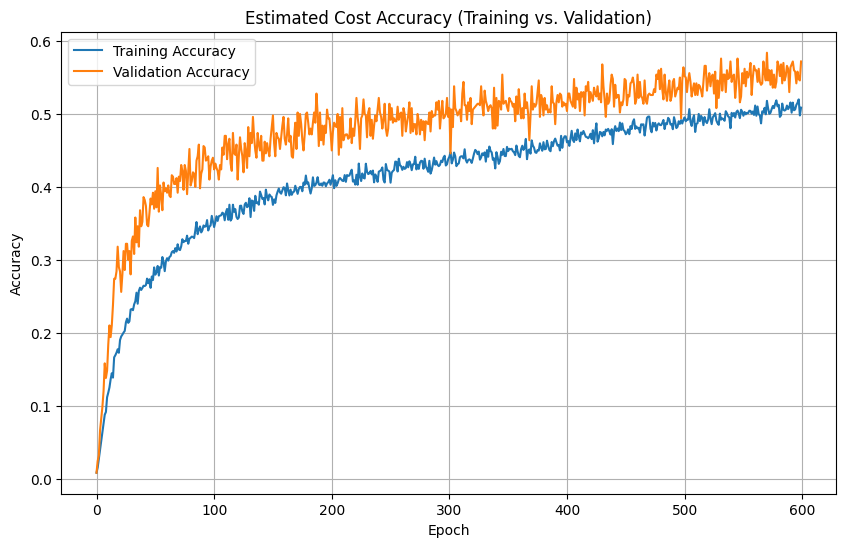

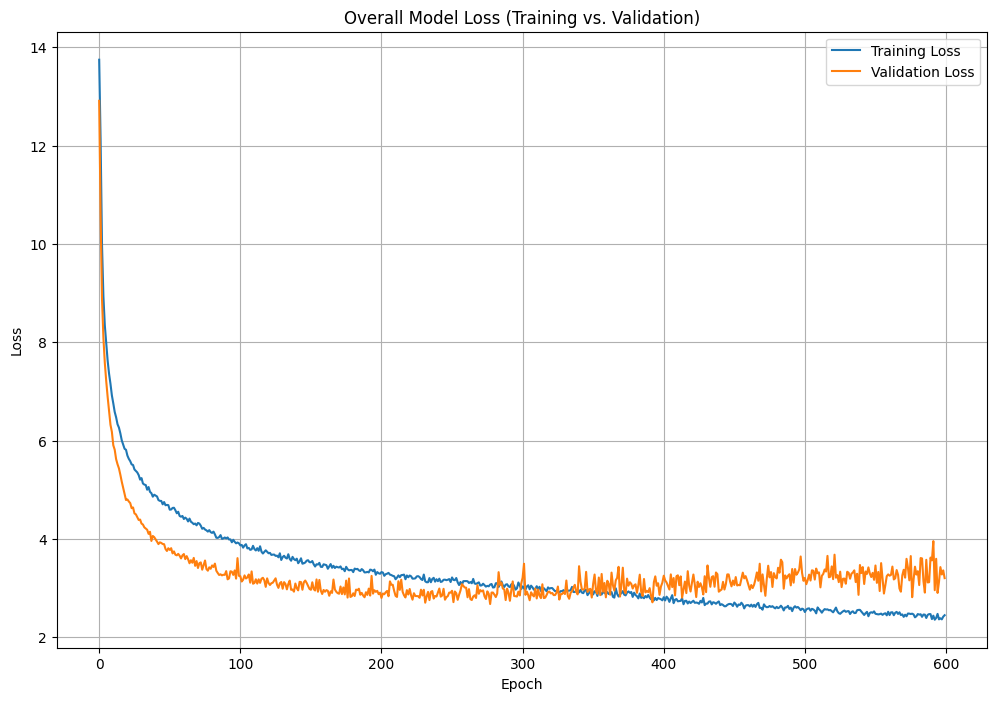


All graphs generated successfully!


In [ ]:
# %% [markdown]
# # AI Model Training for PV System Prediction (V8: ALL CLASSIFICATION)
#
# This version converts the continuous `EstimatedCost(LKR)` output into a **Classification** target by assigning each unique cost value its own class label. This structure ensures that the model predicts one of the exact cost values present in the training data, achieving maximum "lookup" accuracy for all four outputs.

# %% [code]
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import json
from IPython.display import display
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. LOAD DATASET
# ---------------------------------------------------------
file_path = 'SmartPlannerDataset2026.csv'
try:
    df = pd.read_csv(file_path)
    print("Dataset Loaded Successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please upload the file to Colab.")
    raise

# ---------------------------------------------------------
# 2. DATA PREPROCESSING
# ---------------------------------------------------------

# Clean Cost
df['EstimatedCost(LKR)'] = df['EstimatedCost(LKR)'].astype(str).str.replace(',', '').astype(float)
# Clean Battery and Create Battery Required Feature
df['Battery(kWh)'] = df['Battery(kWh)'].astype(str).str.replace('No', '0').astype(float)
df['battery_required'] = (df['Battery(kWh)'] > 0).astype(int)

# Select relevant columns
feature_cols = ['PVSize(kW)', 'SystemType', 'battery_required', 'InverterBrand', 'PanelType(W)']
target_cols = ['InverterSize', 'PanelCount', 'Battery(kWh)', 'EstimatedCost(LKR)']
df_clean = df[feature_cols + target_cols].copy()

print("\nData Sample:")
display(df_clean.head())

# ---------------------------------------------------------
# 3. FEATURE ENGINEERING & ENCODING
# ---------------------------------------------------------

# --- INPUTS ---
from sklearn.preprocessing import MinMaxScaler
scaler_numeric = MinMaxScaler()
X_numeric = scaler_numeric.fit_transform(df_clean[['PVSize(kW)', 'PanelType(W)']].values)

ohe_system = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_system = ohe_system.fit_transform(df_clean[['SystemType']])
ohe_brand = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_brand = ohe_brand.fit_transform(df_clean[['InverterBrand']])

X_battery_req = df_clean[['battery_required']].values
X = np.hstack([X_numeric, X_battery_req, X_system, X_brand])
print(f"Input Feature Shape: {X.shape}")

# --- OUTPUTS (4 Classification Targets) ---

# Output 1: InverterSize (Classification)
le_inverter_size = LabelEncoder()
y_inverter_size = le_inverter_size.fit_transform(df_clean['InverterSize'])
num_inv_classes = len(le_inverter_size.classes_)

# Output 2: PanelCount (Classification)
le_panel_count = LabelEncoder()
y_panel_count = le_panel_count.fit_transform(df_clean['PanelCount'])
num_panel_classes = len(le_panel_count.classes_)

# Output 3: Battery(kWh) (Classification)
le_battery = LabelEncoder()
y_battery = le_battery.fit_transform(df_clean['Battery(kWh)'])
num_battery_classes = len(le_battery.classes_)

# Output 4: Estimated Cost (CLASSIFICATION)
le_cost = LabelEncoder()
y_cost = le_cost.fit_transform(df_clean['EstimatedCost(LKR)'])
num_cost_classes = len(le_cost.classes_)
print(f"Total unique cost classes: {num_cost_classes}")

# ---------------------------------------------------------
# 4. SPLIT DATA
# ---------------------------------------------------------
X_train, X_test, y_inv_train, y_inv_test, y_pan_train, y_pan_test, y_bat_train, y_bat_test, y_cost_train, y_cost_test = train_test_split(
    X, y_inverter_size, y_panel_count, y_battery, y_cost, test_size=0.1, random_state=42
)

# ---------------------------------------------------------
# 5. BUILD MODEL
# ---------------------------------------------------------

input_layer = keras.Input(shape=(X.shape[1],), name='user_input')

# Shared Dense Layers (Simplified: 32-32)
x = layers.Dense(32, activation='relu')(input_layer)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Branch 1: Inverter Size Classification
inv_output = layers.Dense(num_inv_classes, activation='softmax', name='inverter_size')(layers.Dense(16, activation='relu')(x))

# Branch 2: Panel Count Classification
pan_output = layers.Dense(num_panel_classes, activation='softmax', name='panel_count')(layers.Dense(16, activation='relu')(x))

# Branch 3: Battery Classification
bat_output = layers.Dense(num_battery_classes, activation='softmax', name='battery_capacity')(layers.Dense(16, activation='relu')(x))

# Branch 4: Estimated Cost Classification
cost_output = layers.Dense(num_cost_classes, activation='softmax', name='estimated_cost')(layers.Dense(16, activation='relu')(x))

model = keras.Model(inputs=input_layer, outputs=[inv_output, pan_output, bat_output, cost_output])

# All outputs are now classification targets
model.compile(
    optimizer='adam',
    loss={
        'inverter_size': 'sparse_categorical_crossentropy',
        'panel_count': 'sparse_categorical_crossentropy',
        'battery_capacity': 'sparse_categorical_crossentropy',
        'estimated_cost': 'sparse_categorical_crossentropy'
    },
    loss_weights={
        'inverter_size': 1.0,
        'panel_count': 1.0,
        'battery_capacity': 1.0,
        'estimated_cost': 1.0
    },
    metrics={'inverter_size': 'accuracy', 'panel_count': 'accuracy', 'battery_capacity': 'accuracy', 'estimated_cost': 'accuracy'}
)

print("\nModel Summary:")
model.summary()

# ---------------------------------------------------------
# 6. TRAIN MODEL (500 Epochs)
# ---------------------------------------------------------
print("\nTraining Model (V8: ALL CLASSIFICATION)...")
history = model.fit(
    X_train,
    {'inverter_size': y_inv_train, 'panel_count': y_pan_train, 'battery_capacity': y_bat_train, 'estimated_cost': y_cost_train},
    validation_data=(X_test, {'inverter_size': y_inv_test, 'panel_count': y_pan_test, 'battery_capacity': y_bat_test, 'estimated_cost': y_cost_test}),
    epochs=600,
    batch_size=16,
    verbose=1
)

print("Training Complete.")

# ---------------------------------------------------------
# 7. CONVERT TO TFLITE
# ---------------------------------------------------------
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('pv_system_model_v8.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model saved as 'pv_system_model_v8.tflite'")

# ---------------------------------------------------------
# 8. SAVE METADATA (Updated for Cost Classification)
# ---------------------------------------------------------
cost_labels = le_cost.inverse_transform(np.arange(num_cost_classes)).tolist()

metadata = {
    "system_type_categories": ohe_system.categories_[0].tolist(),
    "inverter_brand_categories": ohe_brand.categories_[0].tolist(),
    "inverter_size_labels": le_inverter_size.classes_.tolist(),
    "panel_count_labels": le_panel_count.classes_.tolist(),
    "battery_capacity_labels": le_battery.classes_.tolist(),
    "estimated_cost_labels": cost_labels,
    "numeric_scaler_min": scaler_numeric.data_min_.tolist(),
    "numeric_scaler_scale": scaler_numeric.data_range_.tolist(),
    "cost_transformation": "classification_lookup"
}

print("\n=== COPY THIS METADATA FOR YOUR APP ===")
print(json.dumps(metadata, indent=2))
print("=======================================\n")

# ---------------------------------------------------------
# 9. INFERENCE EXAMPLE (Simulating the Mobile App Logic)
# ---------------------------------------------------------
def predict_system(user_input):
    # 1. Parse Input
    pv_size = user_input['MonthlyUsage(kW)']
    sys_type = user_input['SystemType']
    bat_req = user_input['battery_required']
    brand = user_input['inverter_brand']
    panel_type = user_input['PanelType(W)']

    # 2. Preprocess Input Vector
    p_norm = (pv_size - scaler_numeric.data_min_[0]) / scaler_numeric.data_range_[0]
    pt_norm = (panel_type - scaler_numeric.data_min_[1]) / scaler_numeric.data_range_[1]

    sys_vec = (ohe_system.categories_[0] == sys_type).astype(float)
    brand_vec = (ohe_brand.categories_[0] == brand).astype(float)

    features = np.array([[p_norm, pt_norm, float(bat_req)]])
    features = np.hstack([features, sys_vec.reshape(1, -1), brand_vec.reshape(1, -1)])

    # 3. Predict
    preds = model.predict(features, verbose=0)

    # Classification Predictions (Indices)
    pred_inv_idx = np.argmax(preds[0])
    pred_panel_idx = np.argmax(preds[1])
    pred_battery_idx = np.argmax(preds[2])
    pred_cost_idx = np.argmax(preds[3])

    # 4. Decode Outputs
    final_inverter = le_inverter_size.inverse_transform([pred_inv_idx])[0]
    final_panel_count = le_panel_count.inverse_transform([pred_panel_idx])[0]
    final_battery = le_battery.inverse_transform([pred_battery_idx])[0]
    final_cost = le_cost.inverse_transform([pred_cost_idx])[0]

    # 5. Final Formatting
    final_panel_count = np.int64(final_panel_count)
    final_battery = np.float64(round(final_battery, 2))
    final_cost = np.float64(final_cost)

    return {
        "InverterSize": final_inverter,
        "PanelCount": final_panel_count,
        "Battery(kWh)": final_battery,
        "EstimatedCost(LKR)": f"LKR {final_cost:,.0f}"
    }

# ---------------------------------------------------------
# 10. EXPANDED TEST CASES
# ---------------------------------------------------------
print("\n=== EXPANDED TEST PREDICTIONS (V8: ALL CLASSIFICATION MODEL) ===\n")


# Test cases in original format based on new dataset
test_cases = [
    {
        'MonthlyUsage(kW)': 3,
        'SystemType': 'Hybrid',
        'battery_required': 1,
        'inverter_brand': 'Growatt',
        'PanelType(W)': 595
    },
    {
        'MonthlyUsage(kW)': 10,
        'SystemType': 'Off-Grid',
        'battery_required': 1,
        'inverter_brand': 'Huawei',
        'PanelType(W)': 500
    },
    {
        'MonthlyUsage(kW)': 100,
        'SystemType': 'Off-Grid',
        'battery_required': 1,
        'inverter_brand': 'SAKO',
        'PanelType(W)': 640
    },
    {
        'MonthlyUsage(kW)': 40,
        'SystemType': 'Off-Grid',
        'battery_required': 0,
        'inverter_brand': 'Deye',
        'PanelType(W)': 550
    },
    {
        'MonthlyUsage(kW)': 30,
        'SystemType': 'Off-Grid',
        'battery_required': 1,
        'inverter_brand': 'Huawei',
        'PanelType(W)': 550
    },
    {
        'MonthlyUsage(kW)': 8,
        'SystemType': 'Off-Grid',
        'battery_required': 1,
        'inverter_brand': 'Deye',
        'PanelType(W)': 500
    },
    {
        'MonthlyUsage(kW)': 8,
        'SystemType': 'Off-Grid',
        'battery_required': 0,
        'inverter_brand': 'Deye',
        'PanelType(W)': 595
    },
    {
        'MonthlyUsage(kW)': 10,
        'SystemType': 'On-Grid',
        'battery_required': 0,
        'inverter_brand': 'Solax',
        'PanelType(W)': 640
    },
    {
        'MonthlyUsage(kW)': 10,
        'SystemType': 'On-Grid',
        'battery_required': 0,
        'inverter_brand': 'Growatt',
        'PanelType(W)': 595
    },
    {
        'MonthlyUsage(kW)': 30,
        'SystemType': 'On-Grid',
        'battery_required': 0,
        'inverter_brand': 'Solax',
        'PanelType(W)': 640
    },
    {
        'MonthlyUsage(kW)': 15,
        'SystemType': 'On-Grid',
        'battery_required': 0,
        'inverter_brand': 'Huawei',
        'PanelType(W)': 550
    },
    {
        'MonthlyUsage(kW)': 2,
        'SystemType': 'Off-Grid',
        'battery_required': 1,
        'inverter_brand': 'Solax',
        'PanelType(W)': 640
    },
    {
        'MonthlyUsage(kW)': 10,
        'SystemType': 'Off-Grid',
        'battery_required': 1,
        'inverter_brand': 'SAKO',
        'PanelType(W)': 595
    },
    {
        'MonthlyUsage(kW)': 4,
        'SystemType': 'Off-Grid',
        'battery_required': 1,
        'inverter_brand': 'Deye',
        'PanelType(W)': 550
    },
    {
        'MonthlyUsage(kW)': 15,
        'SystemType': 'Hybrid',
        'battery_required': 1,
        'inverter_brand': 'Deye',
        'PanelType(W)': 595
    },
    {
        'MonthlyUsage(kW)': 20,
        'SystemType': 'Hybrid',
        'battery_required': 0,
        'inverter_brand': 'Deye',
        'PanelType(W)': 595
    },
    {
        'MonthlyUsage(kW)': 30,
        'SystemType': 'Hybrid',
        'battery_required': 1,
        'inverter_brand': 'Huawei',
        'PanelType(W)': 550
    },
    {
        'MonthlyUsage(kW)': 8,
        'SystemType': 'Off-Grid',
        'battery_required': 1,
        'inverter_brand': 'SAKO',
        'PanelType(W)': 500
    },
    {
        'MonthlyUsage(kW)': 1,
        'SystemType': 'On-Grid',
        'battery_required': 0,
        'inverter_brand': 'SAKO',
        'PanelType(W)': 500
    },
    {
        'MonthlyUsage(kW)': 10,
        'SystemType': 'On-Grid',
        'battery_required': 0,
        'inverter_brand': 'Solax',
        'PanelType(W)': 550
    }
]

# Expected results for comparison (from the new dataset)
expected_results = {
    1: {'InverterSize': 'Growatt 3 kW', 'PanelCount': 6, 'Battery(kWh)': 10.0, 'EstimatedCost(LKR)': 'LKR 1,252,500'},
    2: {'InverterSize': 'Huawei 10 kW', 'PanelCount': 20, 'Battery(kWh)': 5.0, 'EstimatedCost(LKR)': 'LKR 1,750,000'},
    3: {'InverterSize': 'SAKO 100 kW', 'PanelCount': 200, 'Battery(kWh)': 5.0, 'EstimatedCost(LKR)': 'LKR 12,760,000'},
    4: {'InverterSize': 'Deye 40 kW', 'PanelCount': 80, 'Battery(kWh)': 0.0, 'EstimatedCost(LKR)': 'LKR 5,125,000'},
    5: {'InverterSize': 'Huawei 30 kW', 'PanelCount': 60, 'Battery(kWh)': 5.0, 'EstimatedCost(LKR)': 'LKR 4,225,000'},
    6: {'InverterSize': 'Deye 8 kW', 'PanelCount': 16, 'Battery(kWh)': 15.0, 'EstimatedCost(LKR)': 'LKR 2,110,000'},
    7: {'InverterSize': 'Deye 8 kW', 'PanelCount': 16, 'Battery(kWh)': 0.0, 'EstimatedCost(LKR)': 'LKR 1,352,500'},
    8: {'InverterSize': 'Solax 10 kW', 'PanelCount': 20, 'Battery(kWh)': 0.0, 'EstimatedCost(LKR)': 'LKR 1,410,000'},
    9: {'InverterSize': 'Growatt 10 kW', 'PanelCount': 20, 'Battery(kWh)': 0.0, 'EstimatedCost(LKR)': 'LKR 1,342,500'},
    10: {'InverterSize': 'Solax 30 kW', 'PanelCount': 60, 'Battery(kWh)': 0.0, 'EstimatedCost(LKR)': 'LKR 3,810,000'},
    11: {'InverterSize': 'Huawei 15 kW', 'PanelCount': 30, 'Battery(kWh)': 0.0, 'EstimatedCost(LKR)': 'LKR 1,875,000'},
    12: {'InverterSize': 'Solax 2 kW', 'PanelCount': 4, 'Battery(kWh)': 5.0, 'EstimatedCost(LKR)': 'LKR 1,000,000'},
    13: {'InverterSize': 'SAKO 10 kW', 'PanelCount': 20, 'Battery(kWh)': 10.0, 'EstimatedCost(LKR)': 'LKR 2,192,500'},
    14: {'InverterSize': 'Deye 4 kW', 'PanelCount': 8, 'Battery(kWh)': 5.0, 'EstimatedCost(LKR)': 'LKR 1,105,000'},
    15: {'InverterSize': 'Deye 15 kW', 'PanelCount': 30, 'Battery(kWh)': 20.0, 'EstimatedCost(LKR)': 'LKR 3,292,500'},
    16: {'InverterSize': 'Deye 20 kW', 'PanelCount': 40, 'Battery(kWh)': 0.0, 'EstimatedCost(LKR)': 'LKR 2,692,500'},
    17: {'InverterSize': 'Huawei 30 kW', 'PanelCount': 60, 'Battery(kWh)': 5.0, 'EstimatedCost(LKR)': 'LKR 4,125,000'},
    18: {'InverterSize': 'SAKO 8 kW', 'PanelCount': 16, 'Battery(kWh)': 10.0, 'EstimatedCost(LKR)': 'LKR 1,810,000'},
    19: {'InverterSize': 'SAKO 1 kW', 'PanelCount': 2, 'Battery(kWh)': 0.0, 'EstimatedCost(LKR)': 'LKR 120,000'},
    20: {'InverterSize': 'Solax 10 kW', 'PanelCount': 20, 'Battery(kWh)': 0.0, 'EstimatedCost(LKR)': 'LKR 1,275,000'}
}

# Run all test cases
for i, test_case in enumerate(test_cases, 1):
    print(f"\n{'='*60}")
    print(f"TEST CASE {i}:")
    print(f"{'='*60}")
    print(f"Input Parameters:")
    for key, value in test_case.items():
        print(f"  {key}: {value}")

    print(f"\nPredicted Results:")
    prediction = predict_system(test_case)
    for key, value in prediction.items():
        print(f"  {key}: {value}")

    # Compare with expected results if available
    if i in expected_results:
        print(f"\nExpected Results (from sample data):")
        expected = expected_results[i]
        for key, value in expected.items():
            print(f"  {key}: {value}")

        # Check accuracy
        matches = 0
        total = 4
        for key in expected.keys():
            if key in prediction and prediction[key] == expected[key]:
                matches += 1

        accuracy = (matches / total) * 100
        print(f"\nAccuracy for Test Case {i}: {accuracy:.1f}% ({matches}/{total} correct)")
        if accuracy < 100:
            print("Mismatches:")
            for key in expected.keys():
                if key in prediction and prediction[key] != expected[key]:
                    print(f"  {key}: Predicted '{prediction[key]}' vs Expected '{expected[key]}'")

print("\n" + "="*60)
print("TEST SUMMARY:")
print(f"Total Test Cases Run: {len(test_cases)}")
print(f"Cases with Expected Results: {len(expected_results)}")
print("="*60)

# ---------------------------------------------------------
# 11. PLOT TRAINING AND VALIDATION HISTORY
# ---------------------------------------------------------
print("\nGenerating Training Graphs...")

# Plot Inverter Size Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['inverter_size_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_inverter_size_accuracy'], label='Validation Accuracy')
plt.title('Inverter Size Accuracy (Training vs. Validation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Panel Count Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['panel_count_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_panel_count_accuracy'], label='Validation Accuracy')
plt.title('Panel Count Accuracy (Training vs. Validation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Battery Capacity Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['battery_capacity_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_battery_capacity_accuracy'], label='Validation Accuracy')
plt.title('Battery Capacity Accuracy (Training vs. Validation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Estimated Cost Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['estimated_cost_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_estimated_cost_accuracy'], label='Validation Accuracy')
plt.title('Estimated Cost Accuracy (Training vs. Validation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss Curves
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Overall Model Loss (Training vs. Validation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print("\nAll graphs generated successfully!")

# DEEP ANALYSIS OF MODEL PREDICTIONS - AI Model Training for PV System Prediction (V8: ALL CLASSIFICATION)

DEEP ANALYSIS OF PREDICTION RESULTS

1. ANALYZING COST PREDICTION ACCURACY:
----------------------------------------
Total records: 5000
Exact cost matches: 0 (0.00%)

Cost Error Categories:
  Within ±0.1%: 3275 (65.50%)
  Within ±1%: 3281 (65.62%)
  Within ±5%: 3510 (70.20%)
  Within ±10%: 3818 (76.36%)
  Within ±20%: 4298 (85.96%)
  Within ±50%: 4880 (97.60%)
  Within ±100%: 4979 (99.58%)
  Over 100% error: 21 (0.42%)


2. ANALYZING PANEL COUNT AND BATTERY PREDICTIONS:
----------------------------------------

Panel Count Analysis:
Exact string matches: 3354 (67.08%)
Numeric matches: 3354 (67.08%)

Battery Capacity Analysis:
Exact string matches: 3174 (63.48%)
Numeric matches: 3174 (63.48%)


3. BRAND-SPECIFIC DEEP ANALYSIS:
----------------------------------------

Deye (n=1035):
  Inverter Size: 98.94%
  Panel Count: 63.19%
  Battery: 63.29%
  Cost (exact): 0.00%
  Cost (within 5%): 70.72%
  All correct (cost within 5%): 326/1035 = 31.50%

Growatt (n=936):
  Inverter Size: 91.88%
 

/tmp/ipython-input-726728018.py:223: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


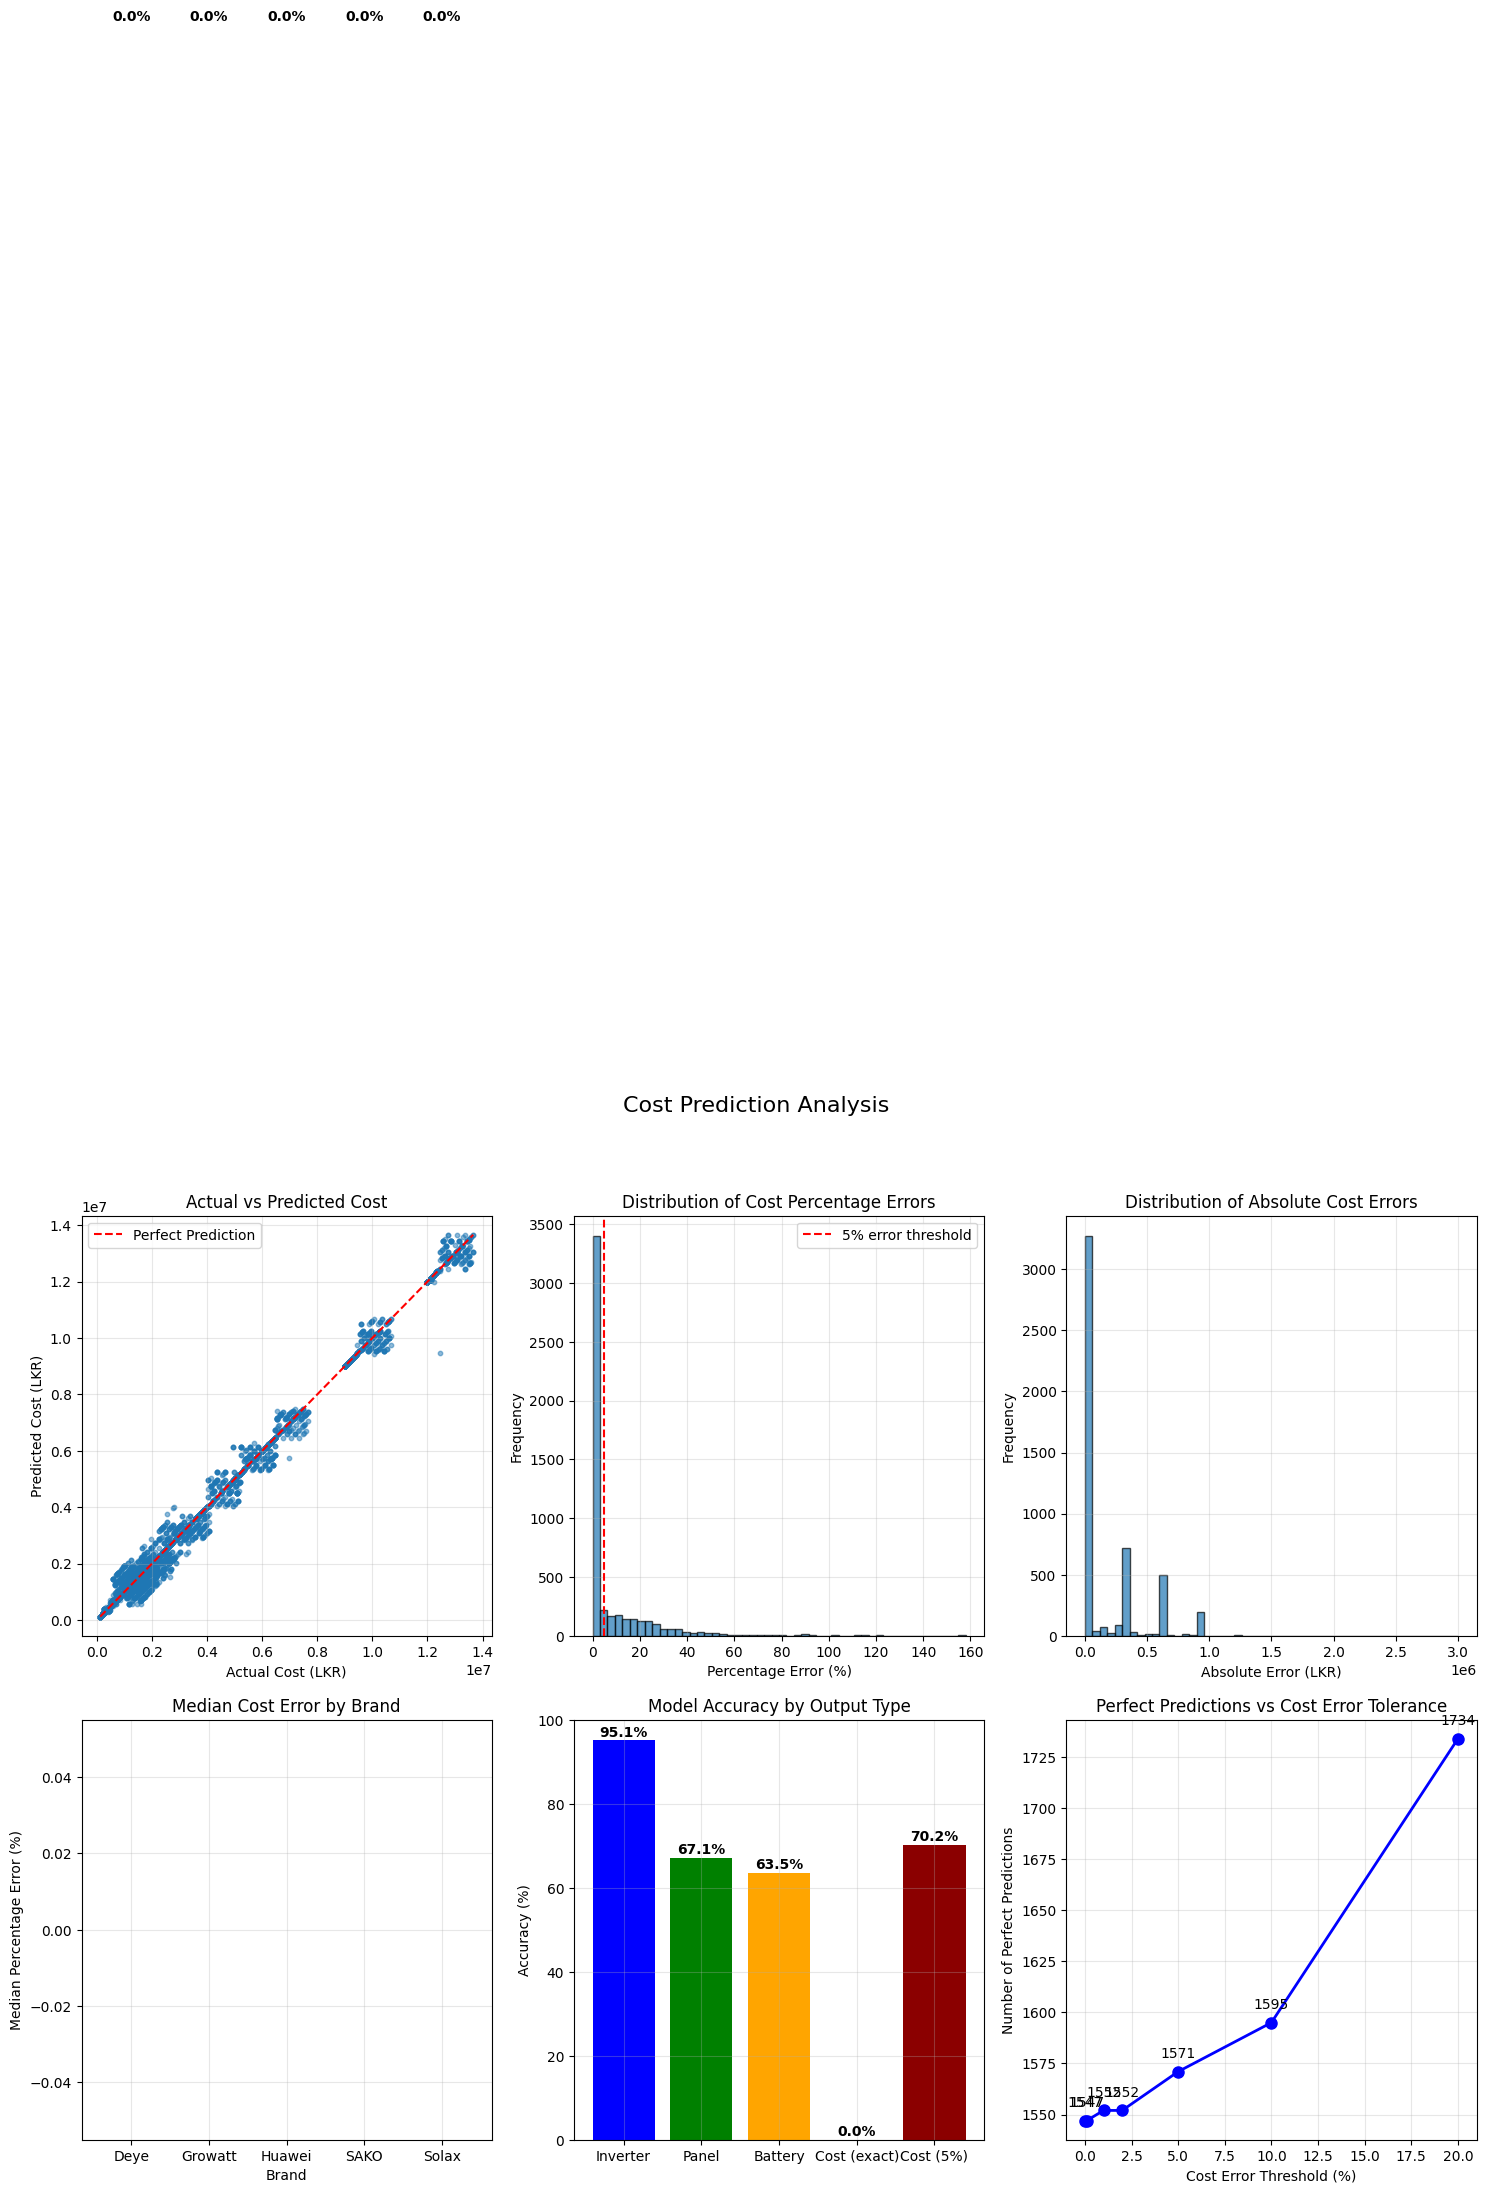



5. SAMPLE PREDICTION ANALYSIS:
----------------------------------------

Sample of predictions with small cost errors (<1%):

Index 2 (Brand: SAKO):
  Inverter: SAKO 100 kW vs SAKO 100 kW ✓
  Panel: 200 vs 200 ✓
  Battery: 10.0 vs 5.0 ✗
  Cost: 12,760,000 vs 12,760,000 (error: 0.00%)

Index 3 (Brand: Deye):
  Inverter: Deye 40 kW vs Deye 40 kW ✓
  Panel: 60 vs 80 ✗
  Battery: 0.0 vs 0.0 ✓
  Cost: 5,125,000 vs 5,125,000 (error: 0.00%)

Index 4 (Brand: Huawei):
  Inverter: Huawei 30 kW vs Huawei 30 kW ✓
  Panel: 40 vs 60 ✗
  Battery: 15.0 vs 5.0 ✗
  Cost: 4,225,000 vs 4,225,000 (error: 0.00%)

Index 6 (Brand: Deye):
  Inverter: Deye 8 kW vs Deye 8 kW ✓
  Panel: 16 vs 16 ✓
  Battery: 0.0 vs 0.0 ✓
  Cost: 1,352,500 vs 1,352,500 (error: 0.00%)

Index 7 (Brand: Solax):
  Inverter: Solax 10 kW vs Solax 10 kW ✓
  Panel: 20 vs 20 ✓
  Battery: 0.0 vs 0.0 ✓
  Cost: 1,410,000 vs 1,410,000 (error: 0.00%)

Index 8 (Brand: Growatt):
  Inverter: Growatt 10 kW vs Growatt 10 kW ✓
  Panel: 20 vs 20 ✓
 

In [5]:
# %% [markdown]
# # DEEP ANALYSIS OF MODEL PREDICTIONS
#
# Fixed version with typo correction

# %% [code]
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the results from previous test
results_df = pd.read_csv('model_test_results_v8_fixed.csv')

print("="*80)
print("DEEP ANALYSIS OF PREDICTION RESULTS")
print("="*80)

# 1. Check if predictions are actually close (numerical comparison)
print("\n1. ANALYZING COST PREDICTION ACCURACY:")
print("-"*40)

# Convert cost strings to floats for comparison
results_df['actual_cost_float'] = results_df['actual_cost'].astype(float)
results_df['pred_cost_float'] = results_df['pred_cost'].astype(float)

# Calculate percentage error
results_df['cost_error_pct'] = abs((results_df['pred_cost_float'] - results_df['actual_cost_float']) / results_df['actual_cost_float']) * 100
results_df['cost_absolute_error'] = abs(results_df['pred_cost_float'] - results_df['actual_cost_float'])

# Analyze cost errors
print(f"Total records: {len(results_df)}")
print(f"Exact cost matches: {(results_df['cost_correct']).sum()} ({(results_df['cost_correct']).sum()/len(results_df)*100:.2f}%)")

# Categorize cost errors
print("\nCost Error Categories:")
cost_error_thresholds = [0.1, 1, 5, 10, 20, 50, 100]
for threshold in cost_error_thresholds:
    within_threshold = (results_df['cost_error_pct'] <= threshold).sum()
    print(f"  Within ±{threshold}%: {within_threshold} ({within_threshold/len(results_df)*100:.2f}%)")

print(f"  Over 100% error: {(results_df['cost_error_pct'] > 100).sum()} ({(results_df['cost_error_pct'] > 100).sum()/len(results_df)*100:.2f}%)")

# 2. Check if panel count and battery are actually wrong or just string format issues
print("\n\n2. ANALYZING PANEL COUNT AND BATTERY PREDICTIONS:")
print("-"*40)

# Panel count analysis
print("\nPanel Count Analysis:")
panel_correct_numeric = (results_df['pred_panel'] == results_df['actual_panel']).sum()
print(f"Exact string matches: {panel_correct_numeric} ({panel_correct_numeric/len(results_df)*100:.2f}%)")

# Let's check if they're actually numerically the same but different string formats
try:
    # Try converting to integers
    results_df['actual_panel_int'] = results_df['actual_panel'].astype(int)
    results_df['pred_panel_int'] = results_df['pred_panel'].astype(int)
    panel_numeric_correct = (results_df['actual_panel_int'] == results_df['pred_panel_int']).sum()
    print(f"Numeric matches: {panel_numeric_correct} ({panel_numeric_correct/len(results_df)*100:.2f}%)")

    if panel_numeric_correct > panel_correct_numeric:
        print("NOTE: Some panel counts are numerically correct but string format differs!")
except:
    print("Could not convert panel counts to integers for comparison")

# Battery analysis - FIXED TYPO HERE
print("\nBattery Capacity Analysis:")
battery_correct_numeric = (results_df['pred_battery'] == results_df['actual_battery']).sum()
print(f"Exact string matches: {battery_correct_numeric} ({battery_correct_numeric/len(results_df)*100:.2f}%)")

# Try float comparison for battery
try:
    results_df['actual_battery_float'] = results_df['actual_battery'].astype(float)
    results_df['pred_battery_float'] = results_df['pred_battery'].astype(float)
    battery_numeric_correct = (results_df['actual_battery_float'] == results_df['pred_battery_float']).sum()
    print(f"Numeric matches: {battery_numeric_correct} ({battery_numeric_correct/len(results_df)*100:.2f}%)")

    if battery_numeric_correct > battery_correct_numeric:
        print("NOTE: Some battery values are numerically correct but string format differs!")
except Exception as e:
    print(f"Could not convert battery values to floats for comparison: {e}")

# 3. Brand-specific deep analysis
print("\n\n3. BRAND-SPECIFIC DEEP ANALYSIS:")
print("-"*40)

brands = ['Deye', 'Growatt', 'Huawei', 'SAKO', 'Solax']

for brand in brands:
    brand_df = results_df[results_df['brand'] == brand]
    if len(brand_df) > 0:
        print(f"\n{brand} (n={len(brand_df)}):")

        # Inverter accuracy
        inv_acc = brand_df['inv_correct'].sum() / len(brand_df) * 100

        # Panel count accuracy (numeric)
        panel_acc = (brand_df['actual_panel_int'] == brand_df['pred_panel_int']).sum() / len(brand_df) * 100

        # Battery accuracy (numeric)
        battery_acc = (brand_df['actual_battery_float'] == brand_df['pred_battery_float']).sum() / len(brand_df) * 100

        # Cost accuracy (exact)
        cost_exact_acc = brand_df['cost_correct'].sum() / len(brand_df) * 100

        # Cost accuracy (within 5%)
        cost_close_acc = (brand_df['cost_error_pct'] <= 5).sum() / len(brand_df) * 100

        print(f"  Inverter Size: {inv_acc:.2f}%")
        print(f"  Panel Count: {panel_acc:.2f}%")
        print(f"  Battery: {battery_acc:.2f}%")
        print(f"  Cost (exact): {cost_exact_acc:.2f}%")
        print(f"  Cost (within 5%): {cost_close_acc:.2f}%")

        # All correct (with relaxed cost)
        all_relaxed = ((brand_df['inv_correct']) &
                      (brand_df['actual_panel_int'] == brand_df['pred_panel_int']) &
                      (brand_df['actual_battery_float'] == brand_df['pred_battery_float']) &
                      (brand_df['cost_error_pct'] <= 5)).sum()
        print(f"  All correct (cost within 5%): {all_relaxed}/{len(brand_df)} = {all_relaxed/len(brand_df)*100:.2f}%")

# 4. Visualize the actual vs predicted cost relationship
print("\n\n4. COST PREDICTION ANALYSIS:")
print("-"*40)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Cost Prediction Analysis', fontsize=16)

# Plot 1: Actual vs Predicted Cost (scatter)
ax1 = axes[0, 0]
ax1.scatter(results_df['actual_cost_float'], results_df['pred_cost_float'], alpha=0.5, s=10)
ax1.plot([results_df['actual_cost_float'].min(), results_df['actual_cost_float'].max()],
         [results_df['actual_cost_float'].min(), results_df['actual_cost_float'].max()],
         'r--', label='Perfect Prediction')
ax1.set_xlabel('Actual Cost (LKR)')
ax1.set_ylabel('Predicted Cost (LKR)')
ax1.set_title('Actual vs Predicted Cost')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Cost Error Distribution
ax2 = axes[0, 1]
ax2.hist(results_df['cost_error_pct'], bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(x=5, color='red', linestyle='--', label='5% error threshold')
ax2.set_xlabel('Percentage Error (%)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Cost Percentage Errors')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Absolute Cost Error Distribution
ax3 = axes[0, 2]
ax3.hist(results_df['cost_absolute_error'], bins=50, edgecolor='black', alpha=0.7)
ax3.set_xlabel('Absolute Error (LKR)')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Absolute Cost Errors')
ax3.grid(True, alpha=0.3)

# Plot 4: Brand-wise Cost Error
ax4 = axes[1, 0]
brand_errors = []
for brand in brands:
    brand_df = results_df[results_df['brand'] == brand]
    if len(brand_df) > 0:
        median_error = brand_df['cost_error_pct'].median()
        brand_errors.append(median_error)
    else:
        brand_errors.append(0)

bars = ax4.bar(brands, brand_errors, color=['red', 'blue', 'green', 'orange', 'purple'])
ax4.set_xlabel('Brand')
ax4.set_ylabel('Median Percentage Error (%)')
ax4.set_title('Median Cost Error by Brand')
ax4.grid(True, alpha=0.3)

# Add value labels
for bar, error in zip(bars, brand_errors):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{error:.1f}%', ha='center', fontweight='bold')

# Plot 5: Accuracy by Output Type (with relaxed cost)
ax5 = axes[1, 1]
outputs = ['Inverter', 'Panel', 'Battery', 'Cost (exact)', 'Cost (5%)']
accuracies = [
    results_df['inv_correct'].sum() / len(results_df) * 100,
    (results_df['actual_panel_int'] == results_df['pred_panel_int']).sum() / len(results_df) * 100,
    (results_df['actual_battery_float'] == results_df['pred_battery_float']).sum() / len(results_df) * 100,
    results_df['cost_correct'].sum() / len(results_df) * 100,
    (results_df['cost_error_pct'] <= 5).sum() / len(results_df) * 100
]

bars = ax5.bar(outputs, accuracies, color=['blue', 'green', 'orange', 'red', 'darkred'])
ax5.set_ylim(0, 100)
ax5.set_ylabel('Accuracy (%)')
ax5.set_title('Model Accuracy by Output Type')
ax5.grid(True, alpha=0.3)

# Add value labels
for bar, acc in zip(bars, accuracies):
    ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{acc:.1f}%', ha='center', fontweight='bold')

# Plot 6: All correct with different cost thresholds
ax6 = axes[1, 2]
thresholds = [0, 0.1, 1, 2, 5, 10, 20]
all_correct_counts = []
for threshold in thresholds:
    count = ((results_df['inv_correct']) &
            (results_df['actual_panel_int'] == results_df['pred_panel_int']) &
            (results_df['actual_battery_float'] == results_df['pred_battery_float']) &
            (results_df['cost_error_pct'] <= threshold)).sum()
    all_correct_counts.append(count)

ax6.plot(thresholds, all_correct_counts, 'bo-', linewidth=2, markersize=8)
ax6.set_xlabel('Cost Error Threshold (%)')
ax6.set_ylabel('Number of Perfect Predictions')
ax6.set_title('Perfect Predictions vs Cost Error Tolerance')
ax6.grid(True, alpha=0.3)

# Add value labels
for i, (x, y) in enumerate(zip(thresholds, all_correct_counts)):
    ax6.annotate(f'{y}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

# 5. Sample predictions analysis
print("\n\n5. SAMPLE PREDICTION ANALYSIS:")
print("-"*40)

print("\nSample of predictions with small cost errors (<1%):")
small_error_df = results_df[results_df['cost_error_pct'] < 1].head(10)
for idx, row in small_error_df.iterrows():
    print(f"\nIndex {row['index']} (Brand: {row['brand']}):")
    print(f"  Inverter: {row['pred_inverter']} vs {row['actual_inverter']} {'✓' if row['inv_correct'] else '✗'}")
    print(f"  Panel: {row['pred_panel']} vs {row['actual_panel']} {'✓' if row['actual_panel_int'] == row['pred_panel_int'] else '✗'}")
    print(f"  Battery: {row['pred_battery']} vs {row['actual_battery']} {'✓' if row['actual_battery_float'] == row['pred_battery_float'] else '✗'}")
    print(f"  Cost: {row['pred_cost_float']:,.0f} vs {row['actual_cost_float']:,.0f} (error: {row['cost_error_pct']:.2f}%)")

print("\n\nSample of predictions with large cost errors (>50%):")
large_error_df = results_df[results_df['cost_error_pct'] > 50].head(10)
for idx, row in large_error_df.iterrows():
    print(f"\nIndex {row['index']} (Brand: {row['brand']}):")
    print(f"  Inverter: {row['pred_inverter']} vs {row['actual_inverter']} {'✓' if row['inv_correct'] else '✗'}")
    print(f"  Panel: {row['pred_panel']} vs {row['actual_panel']} {'✓' if row['actual_panel_int'] == row['pred_panel_int'] else '✗'}")
    print(f"  Battery: {row['pred_battery']} vs {row['actual_battery']} {'✓' if row['actual_battery_float'] == row['pred_battery_float'] else '✗'}")
    print(f"  Cost: {row['pred_cost_float']:,.0f} vs {row['actual_cost_float']:,.0f} (error: {row['cost_error_pct']:.2f}%)")

# 6. Summary statistics
print("\n\n6. SUMMARY STATISTICS:")
print("-"*40)

print(f"\nOverall Statistics:")
print(f"Total predictions: {len(results_df)}")

# Calculate true accuracies (with numeric comparison)
true_inv_acc = results_df['inv_correct'].sum() / len(results_df) * 100
true_panel_acc = (results_df['actual_panel_int'] == results_df['pred_panel_int']).sum() / len(results_df) * 100
true_battery_acc = (results_df['actual_battery_float'] == results_df['pred_battery_float']).sum() / len(results_df) * 100

print(f"\nTrue Accuracy (numeric comparison):")
print(f"  Inverter Size: {true_inv_acc:.2f}%")
print(f"  Panel Count: {true_panel_acc:.2f}%")
print(f"  Battery Capacity: {true_battery_acc:.2f}%")
print(f"  Cost (exact match): {results_df['cost_correct'].sum()/len(results_df)*100:.2f}%")

# Cost error statistics
print(f"\nCost Error Statistics:")
print(f"  Mean absolute error: {results_df['cost_absolute_error'].mean():,.0f} LKR")
print(f"  Median absolute error: {results_df['cost_absolute_error'].median():,.0f} LKR")
print(f"  Mean percentage error: {results_df['cost_error_pct'].mean():.2f}%")
print(f"  Median percentage error: {results_df['cost_error_pct'].median():.2f}%")

# What percentage are within reasonable bounds?
within_1_percent = (results_df['cost_error_pct'] <= 1).sum() / len(results_df) * 100
within_5_percent = (results_df['cost_error_pct'] <= 5).sum() / len(results_df) * 100
within_10_percent = (results_df['cost_error_pct'] <= 10).sum() / len(results_df) * 100

print(f"\nCost Predictions within Error Thresholds:")
print(f"  Within 1%: {within_1_percent:.2f}%")
print(f"  Within 5%: {within_5_percent:.2f}%")
print(f"  Within 10%: {within_10_percent:.2f}%")

# All outputs correct with different cost tolerances
print(f"\nAll Outputs Correct (with cost tolerance):")
for threshold in [0, 1, 2, 5, 10]:
    all_correct = ((results_df['inv_correct']) &
                  (results_df['actual_panel_int'] == results_df['pred_panel_int']) &
                  (results_df['actual_battery_float'] == results_df['pred_battery_float']) &
                  (results_df['cost_error_pct'] <= threshold)).sum()
    print(f"  Cost within {threshold}%: {all_correct} ({all_correct/len(results_df)*100:.2f}%)")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

# Save detailed analysis
analysis_df = results_df[['index', 'brand', 'actual_inverter', 'pred_inverter', 'inv_correct',
                         'actual_panel', 'pred_panel', 'actual_panel_int', 'pred_panel_int',
                         'actual_battery', 'pred_battery', 'actual_battery_float', 'pred_battery_float',
                         'actual_cost_float', 'pred_cost_float', 'cost_error_pct', 'cost_absolute_error']]

analysis_df.to_csv('detailed_analysis_v8.csv', index=False)
print(f"\nDetailed analysis saved to 'detailed_analysis_v8.csv'")